# <p style="font-family: Garamond; font-size: 35px; word-spacing: 10px; padding: 25px; text-align: center; color: #ffffff; border-radius: 25px;  font-weight: bold; background-color: #06066F">EDA FOR BINARY CLASSIFICATION OF INSURANCE CROSS SELLING</p>

**Context:** An insurance company that has provided health insurance to its customers, now needs to build a model to predict whether last year's policyholders would also be interested in purchasing a vehicle insurance.  

The **objective of this competition is to predict which customers respond positively to an automobile insurance offer** based on 10 factors:   
- Gender. Gender of the customer
- Age. Age of the customer
- Driving_License. 0: Customer does not have DL, 1: Customer already has DL
- Region_Code. Unique code for the region of the customer
- Previously_Insured. 1: Customer already has Vehicle Insurance, 0: Customer doesn't have Vehicle Insurance
- Vehicle_Age. Age of the Vehicle
- Vehicle_Damage. 1: Customer got his/her vehicle damaged in the past. 0: Customer didn't get his/her vehicle damaged in the past.
- Annual_Premium. The amount customer needs to pay as premium in the year
- Policy_Sales_Channel. Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
- Vintage. Number of days the customer has been associated with the company.


**Response.** 1: Customer is interested, 0: Customer is not interested

The datasets for this competition (both train and test) were generated from a deep learning model trained on the [Health Insurance Cross Sell Prediction Data](https://www.kaggle.com/datasets/annantkumarsingh/health-insurance-cross-sell-prediction-data/data).

**Submissions are evaluated using area under the ROC curve.**  


In this notebook we'll perform Exploratory Data Analysis:   
- Univariate, Bivariate and Multivariate Analysis,   
- Measures of Association: Spearman Correlation, Cramér's V, and Mutual Information,    
- Hierarchical Clustering of Features, and   
- Factor Analysis for Mixed Data.    

Full description available at [Health Insurance Cross Sell Prediction](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction/data)

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 10px; padding: 15px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #06066F;">LIBRARIES</p>

In [1]:
pip install prince # perform factor analysis for mixed data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 6.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.patches import Rectangle
import seaborn as sns
plt.style.use('ggplot')

import os

import statsmodels.api as sm
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler

import prince

# Remove the max column restriction for displaying on the screen
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")
    
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from IPython.display import Markdown as md

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [3]:
# Helper functions

import random as py_random
import pickle

def reset_random_seeds(seed=42):
    ''' Set all seeds for random numbers to get reproducibility.'''
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    py_random.seed(seed)


reset_random_seeds()


def load(file_name):
    with open(file_name, 'rb') as pickle_file:
        return pickle.load(pickle_file)

    
def save(file_name, data):
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)
        
        
def plot_matrix(matrix, figsize, text='', with_mask=False):
        
    mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)
    fig = plt.figure(figsize=figsize)
    if with_mask:
        ax= sns.heatmap(matrix, annot=True, fmt=',.2f', cmap='coolwarm', mask=mask)
    else:
        ax= sns.heatmap(matrix, annot=True, fmt=',.2f', cmap='coolwarm')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
    ax.set_title(text)
    fig.autofmt_xdate() # it helps to rotate ticklabels if they are long

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 10px; padding: 15px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #06066F;">DATA LOADING</p>

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv', index_col='id')
test  = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv', index_col='id')

initial_features = train.columns[:-1].to_list()

display(md(f'''
**train shape = {train.shape} (including target)**   
**test shape  = {test.shape}**  

**train dataset:**    
'''))
train.head()


**train shape = (11504798, 11) (including target)**   
**test shape  = (7669866, 10)**  

**train dataset:**    


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


# <p style="font-family: Garamond; font-size: 25px; word-spacing: 10px; padding: 15px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #06066F;">EDA: UNIVARIATE ANALYSIS</p>

In [5]:
nominal_features     = ['Region_Code', 'Policy_Sales_Channel']
ordinal_features     = ['Vehicle_Age']
binary_features      = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage']
categorical_features = nominal_features + ordinal_features + binary_features
discrete_features    = ['Age', 'Vintage']
continuous_features  = ['Annual_Premium']
numerical_features   = discrete_features + continuous_features

display(md(f'''
**Train shape = {train.shape} (including target)**           
Number of missing values in train set = {train.isna().sum().sum()}   
Number of duplicates rows in train set = {sum(train[initial_features].duplicated())}   

**Test shape = {test.shape}**     
Number of missing values in test set = {test.isna().sum().sum()}   

**Number of features = {len(initial_features)}**   
- **Categorical = {len(categorical_features)} ( nominal = {len(nominal_features)} -- ordinal = {len(ordinal_features)} -- binary = {len(binary_features)} )**   
- **Numerical   = {len(numerical_features)} ( discrete = {len(discrete_features)} -- continous = {len(continuous_features)} )**   

**Features:**   
- **Nominal:** {nominal_features}    
- **Ordinal:** {ordinal_features}   
- **Binary:** {binary_features}   
- **Discrete:** {discrete_features}   
- **Continuous:** {continuous_features}   
'''))


**Train shape = (11504798, 11) (including target)**           
Number of missing values in train set = 0   
Number of duplicates rows in train set = 0   

**Test shape = (7669866, 10)**     
Number of missing values in test set = 0   

**Number of features = 10**   
- **Categorical = 7 ( nominal = 2 -- ordinal = 1 -- binary = 4 )**   
- **Numerical   = 3 ( discrete = 2 -- continous = 1 )**   

**Features:**   
- **Nominal:** ['Region_Code', 'Policy_Sales_Channel']    
- **Ordinal:** ['Vehicle_Age']   
- **Binary:** ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage']   
- **Discrete:** ['Age', 'Vintage']   
- **Continuous:** ['Annual_Premium']   


# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">CATEGORICAL SUMMARIES</p>

In [6]:
# Re-encode nominal features for a more compact histogram

#for col in categorical_features:
#    print(f'{col}  --  number of unique values: {train[col].nunique()}  --  values: {train[col].unique()}')

ordinal_encoder = {}
for col in ['Region_Code', 'Policy_Sales_Channel', 'Gender', 'Vehicle_Damage']:
    ordinal_encoder[col] = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=train[col].nunique(), dtype=np.uint8)
    train[col] = ordinal_encoder[col].fit_transform(train[col].array.reshape(-1, 1))
    test[col] = ordinal_encoder[col].transform(test[col].array.reshape(-1, 1))  

col = 'Vehicle_Age'
categories = [['< 1 Year', '1-2 Year', '> 2 Years']]
ordinal_encoder[col] = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=train[col].nunique(), dtype=np.uint8) 
train[col] = ordinal_encoder[col].fit_transform(train[col].array.reshape(-1, 1))
test[col] = ordinal_encoder[col].transform(test[col].array.reshape(-1, 1))  

for col in categorical_features:
    train[col] = train[col].astype(np.uint8)
    test[col] = test[col].astype(np.uint8)
    
    
cols_dict = {'nunique':'number of unique values'}
statistical_summary_for_categoricals = train[categorical_features].agg(['nunique', 'min', 'max', 'median']).rename(cols_dict, axis=0).T
statistical_summary_for_categoricals['mode'] = train[categorical_features].agg('mode').values[0]
statistical_summary_for_categoricals['mode ratio (%)'] = train[categorical_features].apply(lambda x: x.value_counts(normalize=True).max(), axis=0).values * 100

statistical_summary_for_categoricals.astype('int')

,number of unique values,min,max,median,mode,mode ratio (%)
Region_Code,54,0,53,28,28,29
Policy_Sales_Channel,152,0,151,141,142,36
Vehicle_Age,3,0,2,1,1,52
Gender,2,0,1,1,1,54
Driving_License,2,0,1,1,1,99
Previously_Insured,2,0,1,0,0,53
Vehicle_Damage,2,0,1,1,1,50


In [7]:
def check_correlative_numbers(df_as_string):
    '''It checks if the unique values of each categorical feature are correlative.'''
    
    check = lambda x: x['nunique'] - (x['max'] - x['min'] + 1)
    features_check = globals()[df_as_string][categorical_features].agg(['nunique', 'min', 'max'], axis=0).T.agg(check, axis=1)
    features_no_correlative = features_check[features_check!=0].index.to_list()
    print(f'All features have correlative integer values in {df_as_string} set = {str(len(features_no_correlative)==0)}')
    

def check_values_not_in_intersection():
    '''For each feature, it checks if the elements in train and test datasets are identical.'''
    
    in_train_not_in_test = {}
    in_test_not_in_train = {}
    for col in categorical_features: 
        diff_set = set(train[col].unique()).difference(set(test[col].unique()))
        if len(diff_set) > 0: in_train_not_in_test[col] = sorted(diff_set)
        diff_set = set(test[col].unique()).difference(set(train[col].unique()))
        if len(diff_set) > 0: in_test_not_in_train[col] = sorted(diff_set)

    print('(Feature, list of integer values) present in train set but not in test set:')
    df_aux_train = pd.DataFrame({'feature':list(in_train_not_in_test.keys()), 'values in train set':in_train_not_in_test.values()})
    df_aux_train['number of rows'] = df_aux_train.apply(lambda x: train[train[x['feature']].isin(x['values in train set'])].shape[0], axis=1)
    display(df_aux_train)
    print()
    print('(Feature, list of integer values) present in test set but not in train set:')
    df_aux_test = pd.DataFrame({'feature':list(in_test_not_in_train.keys()), 'values in test set':in_test_not_in_train.values()})
    df_aux_test['number of rows'] = df_aux_test.apply(lambda x: test[test[x['feature']].isin(x['values in test set'])].shape[0], axis=1)
    display(df_aux_test)
    return df_aux_train, df_aux_test


print()
check_correlative_numbers('train')
check_correlative_numbers('test')
print()
just_in_train, just_in_test = check_values_not_in_intersection()


All features have correlative integer values in train set = True
All features have correlative integer values in test set = False

(Feature, list of integer values) present in train set but not in test set:


,feature,values in train set,number of rows
0,Region_Code,[40],1
1,Policy_Sales_Channel,"[4, 5, 32]",7



(Feature, list of integer values) present in test set but not in train set:


,feature,values in test set,number of rows
0,Policy_Sales_Channel,[152],3


# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">NUMERICAL SUMMARIES</p>

In [8]:
train[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,11504798.0,38.383563,14.993459,20.0,24.0,36.0,49.0,85.0
Vintage,11504798.0,163.897744,79.979531,10.0,99.0,166.0,232.0,299.0
Annual_Premium,11504798.0,30461.370411,16454.745205,2630.0,25277.0,31824.0,39451.0,540165.0


# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">HISTOGRAMS</p>

In [9]:
def plot_histograms_for_categorical_discrete(features, cols_number=3, col_mul=5, row_mul=3, title=''):
    '''It plots histograms for train and test datasets side by side.'''

    rows_number = len(features)//cols_number + min(1, len(features)%cols_number)
    
    if cols_number*rows_number>1:
        fig, axs = plt.subplots(rows_number, cols_number, figsize=(col_mul*cols_number, row_mul*rows_number))
        axs= axs.ravel()
    else:
        fig, ax = plt.subplots(1, 1, figsize=(col_mul, row_mul))
        axs = [ax]
    
    bar_width    = 0.4 # bar width

    for col,ax in zip(features, axs):
        
        hist_train = train[col].value_counts(normalize=True)
        hist_test = test[col].value_counts(normalize=True)
        
        ax.bar(hist_train.index - bar_width/2, hist_train.values, width=bar_width, align='center', fill=True, label='train')
        ax.bar(hist_test.index + bar_width/2, hist_test.values, width=bar_width, align='center', fill=True, label='test')
        
        if col in binary_features + ['Vehicle_Age']:
            labels = list(ordinal_encoder[col].categories_[0]) if col in ['Gender', 'Vehicle_Damage', 'Vehicle_Age'] else ['No', 'Yes']
            ticks = range(len(labels))
            ax.set_xticks(ticks=ticks, labels=labels)

        ax.set_title(col, fontsize = 11, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Probability')
        ax.legend(loc='best', title='')

    for i in range(len(features), rows_number*cols_number):
        axs[i].axis('off')
    fig.suptitle(title, fontsize=15, fontweight='bold', y=.995)
    fig.tight_layout()
    
#----------------------------------------------------------------------------------------------------------------    
    
def plot_histograms_for_discrete_continuous(features, bins=40, cols_number=3, col_mul=5, row_mul=3, title=''):
    
    rows_number = len(features)//cols_number + min(1, len(features)%cols_number)
    
    if cols_number*rows_number>1:
        fig, axs = plt.subplots(rows_number, cols_number, figsize=(col_mul*cols_number, row_mul*rows_number))
        axs      = axs.ravel()
    else:
        fig, ax = plt.subplots(1, 1, figsize=(col_mul, row_mul))
        axs = [ax]
    
    for col,ax in zip(features, axs):
        ax.hist([train[col], test[col]], density=True, fill=True, label=['train', 'test'], bins=bins)
        ax.set_title(col, fontsize = 11, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Density')
        ax.legend(loc='best', title='')

    for i in range(len(features), rows_number*cols_number):
        axs[i].axis('off')
    fig.suptitle(title, fontsize=15, fontweight='bold', y=.995)
    fig.tight_layout()

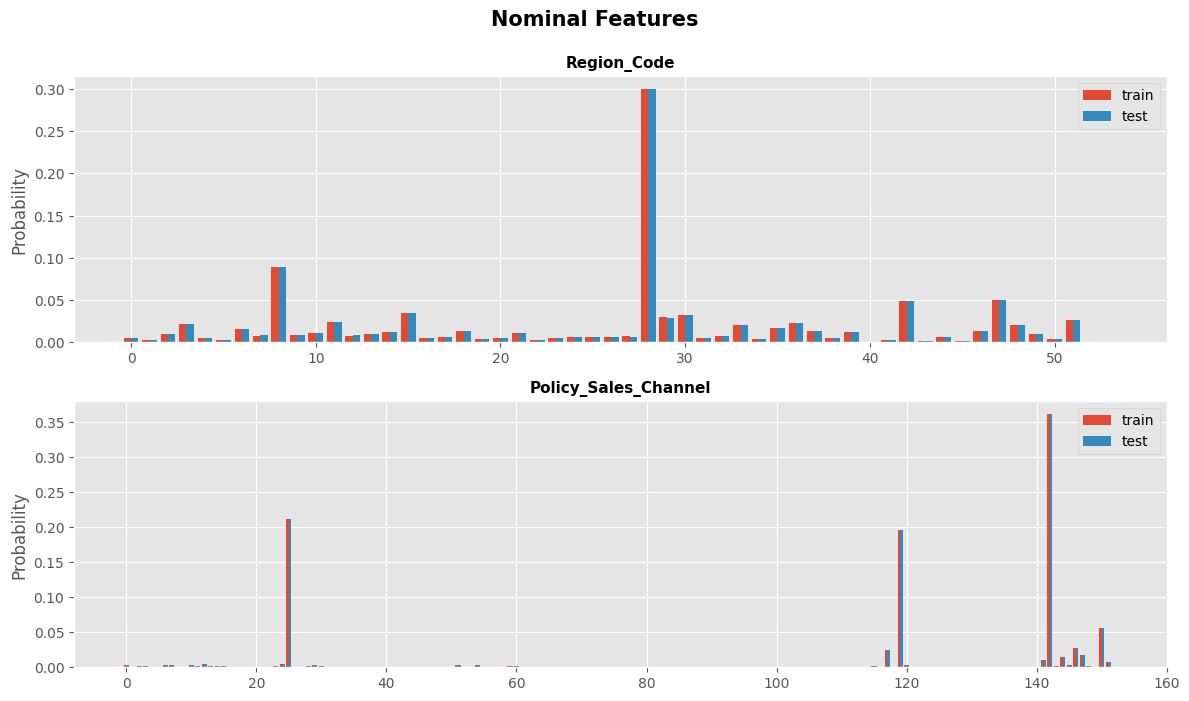

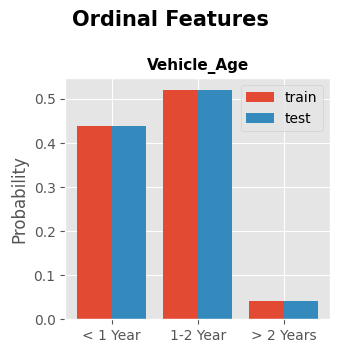

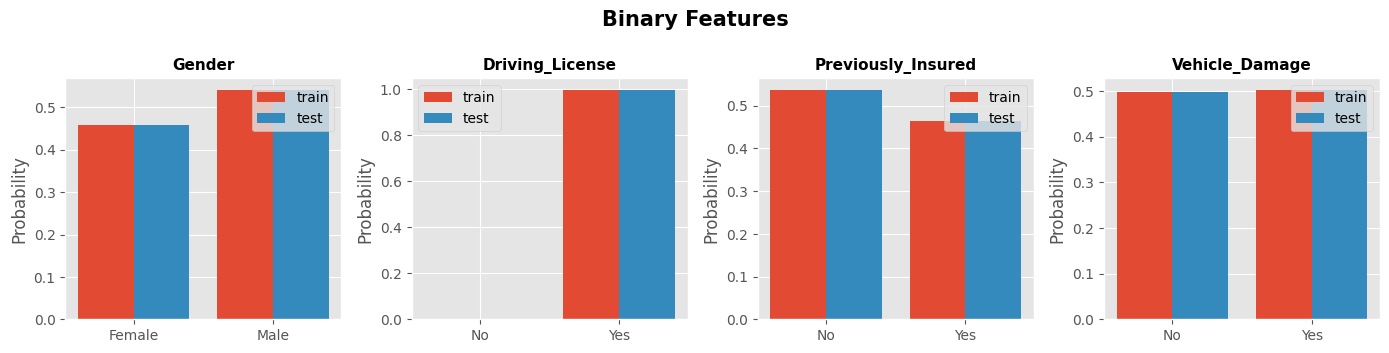

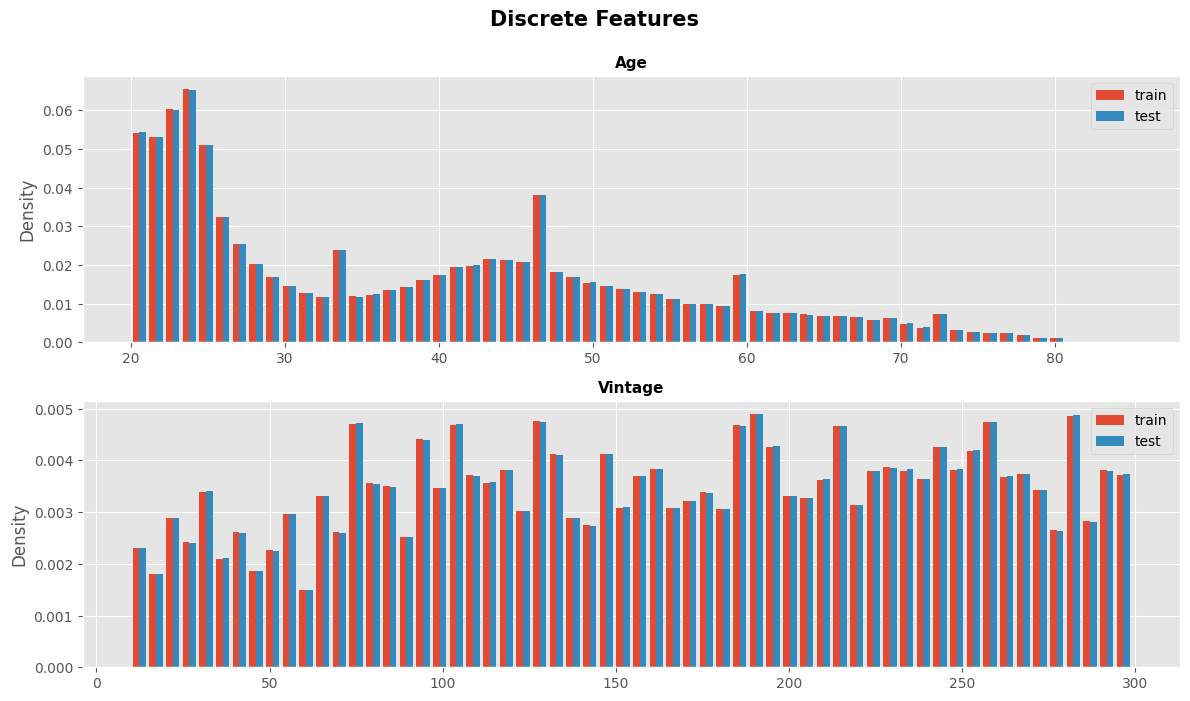

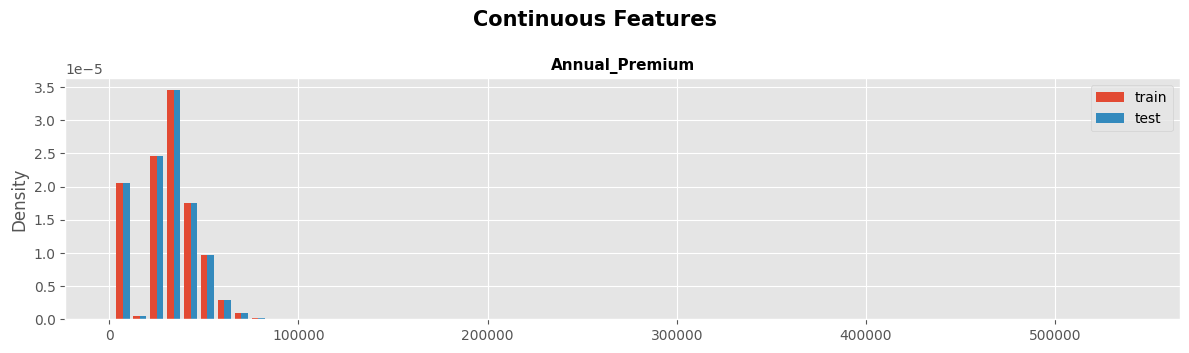

In [10]:
plot_histograms_for_categorical_discrete(features=nominal_features, cols_number=1, col_mul=12.0, row_mul=3.5, title='Nominal Features')
plot_histograms_for_categorical_discrete(features=ordinal_features, cols_number=1, col_mul=3.5, row_mul=3.5, title='Ordinal Features')
plot_histograms_for_categorical_discrete(features=binary_features, cols_number=4, col_mul=3.5, row_mul=3.5, title='Binary Features')
plot_histograms_for_discrete_continuous(features=discrete_features, cols_number=1, col_mul=12.0, row_mul=3.5, title='Discrete Features', bins=60)
plot_histograms_for_discrete_continuous(features=continuous_features, cols_number=1, col_mul=12.0, row_mul=3.5, title='Continuous Features', bins=60)

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">COMPARISON OF DISTRIBUTIONS</p>

In [11]:
display(md(f'''
By looking at the histograms of the features of the train and test datasets, we can say that:
- Their distributions look very similar, and  
- Distributions of numerical features are not normally distributed.  

We can run a hypothesis test to find out if two samples come from the same distribution; however, when dealing with large samples, 
even very small differences between groups can become statistically, but not practically, significant due to the large sample size. 
Let's see what happens in this case.   

First of all, we know that for {set(just_in_train['feature']).union(just_in_test['feature'])} features, train and test sets differ by a few values, 
although they are too few to be considered practically significant.
'''))

print('\nValues in train but not in test set:')
display(just_in_train)
print('\nValues in test but not in train set:')
display(just_in_test)


By looking at the histograms of the features of the train and test datasets, we can say that:
- Their distributions look very similar, and  
- Distributions of numerical features are not normally distributed.  

We can run a hypothesis test to find out if two samples come from the same distribution; however, when dealing with large samples, 
even very small differences between groups can become statistically, but not practically, significant due to the large sample size. 
Let's see what happens in this case.   

First of all, we know that for {'Policy_Sales_Channel', 'Region_Code'} features, train and test sets differ by a few values, 
although they are too few to be considered practically significant.



Values in train but not in test set:


,feature,values in train set,number of rows
0,Region_Code,[40],1
1,Policy_Sales_Channel,"[4, 5, 32]",7



Values in test but not in train set:


,feature,values in test set,number of rows
0,Policy_Sales_Channel,[152],3


Let's perfom a **K-Sample Anderson-Darling Test** [1] to compare two distributions (discrete or continuous) with different sizes, 
computing A2akN according to equation 7 of Scholz & Stephens. This test can deal with tied observations.    

- Under the null hypothesis H0, train and test datasets come from the same unknown distribution.    
- Let's consider significance level alpha = 5%

References:  
[1] Scholz, F. W and Stephens, M. A. (1987), K-Sample Anderson-Darling Tests, 
Journal of the American Statistical Association, Vol. 82, pp. 918-924. 
Paper available [<u>here</u>](https://faculty.washington.edu/fscholz/Papers/ADk.pdf)     

In [12]:
for col in initial_features:
    res = stats.anderson_ksamp([train[col], test[col]], midrank=True)
    T = res.statistic # statistic value
    critical_value = res.critical_values[2] # this is the critical value at significance level 5%
    text = 'H0 is rejected' if T >= critical_value else 'We fail to reject H0'
    print(f'- {col}: statistic = {T:.2f}, critical value at significance level 5% = {critical_value:.2f} ==> {text}')

- Gender: statistic = -1.12, critical value at significance level 5% = 1.96 ==> We fail to reject H0
- Age: statistic = -0.29, critical value at significance level 5% = 1.96 ==> We fail to reject H0
- Driving_License: statistic = -1.31, critical value at significance level 5% = 1.96 ==> We fail to reject H0
- Region_Code: statistic = 0.73, critical value at significance level 5% = 1.96 ==> We fail to reject H0
- Previously_Insured: statistic = -1.16, critical value at significance level 5% = 1.96 ==> We fail to reject H0
- Vehicle_Age: statistic = -0.05, critical value at significance level 5% = 1.96 ==> We fail to reject H0
- Vehicle_Damage: statistic = -0.88, critical value at significance level 5% = 1.96 ==> We fail to reject H0
- Annual_Premium: statistic = 0.84, critical value at significance level 5% = 1.96 ==> We fail to reject H0
- Policy_Sales_Channel: statistic = 3.46, critical value at significance level 5% = 1.96 ==> H0 is rejected
- Vintage: statistic = -1.07, critical val

We see that only for the "Policy_Sales_Channel" feature the null hypothesis was rejected.

Let's now perform a **Mann-WhitneyU Test** [1] for ordinal and continuous variables.  
- Under the null hypothesis H0, the distributions of train and test datasets are identical.    
- Let's consider significance level alpha = 5%    

References:   
[1] Mann–Whitney U test, https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [13]:
alpha = 0.05
for col in ordinal_features + numerical_features:
    T, p_value = stats.mannwhitneyu(train[col], test[col], alternative='two-sided', method='asymptotic')
    text = 'H0 is rejected' if p_value <= alpha else 'We fail to reject H0'
    print(f'- {col}: statistic = {T}, p_value = {p_value:0.3f} ==> {text}')

- Vehicle_Age: statistic = 44109599150479.0, p_value = 0.375 ==> We fail to reject H0
- Age: statistic = 44110776820925.0, p_value = 0.431 ==> We fail to reject H0
- Vintage: statistic = 44119034943816.0, p_value = 0.927 ==> We fail to reject H0
- Annual_Premium: statistic = 44109282402818.0, p_value = 0.361 ==> We fail to reject H0


The Mann-Whitney U Test obtained the same results as the Anderson-Darling K-Sample Test: the null hypothesis was not 
rejected for any of the ordinal or continuous features.    

Finally, let's perform a hypothesis test to compare two independent proportions for the binary variables:   
- prop1 = proportions of 1s in train set
- prop2 = proportions of 1s in test set
- H0: prop1 - prop2 = 0 (null hypothesis)  
- H1: prop1 - prop2 != 0 (alternative hypothesis)    
- Let's consider significance level alpha = 5%    

In [14]:
for col in binary_features:    
    count1 = train[col].value_counts()[1]
    count2 = test[col].value_counts()[1]
    nobs1 = len(train)
    nobs2 = len(test)
    diff = count1/nobs1 - count2/nobs2
    alpha = 0.05
      
    # Hypothesis test for comparing two independent proportions
    res = sm.stats.test_proportions_2indep(count1, nobs1, count2, nobs2, value=0, method=None, compare='diff', alternative='two-sided', correction=True, return_results=True)
    
    # Confidence intervals for comparing two independent proportions at significance level 5%
    low, high = sm.stats.confint_proportions_2indep(count1, nobs1, count2, nobs2, method=None, compare='diff', alpha=alpha, correction=True)
    
    text = 'We fail to reject H0' if res.pvalue>alpha else 'Reject H0'
    print(f'- {col}  --  Proportion Difference = {diff:.5f}  --  Confidence Interval = [{low:.5f} , {high:.5f}] --  p-value = {res.pvalue:.5f}  ==> {text}') 

- Gender  --  Proportion Difference = 0.00009  --  Confidence Interval = [-0.00037 , 0.00054] --  p-value = 0.69948  ==> We fail to reject H0
- Driving_License  --  Proportion Difference = 0.00000  --  Confidence Interval = [-0.00004 , 0.00004] --  p-value = 0.95484  ==> We fail to reject H0
- Previously_Insured  --  Proportion Difference = -0.00008  --  Confidence Interval = [-0.00054 , 0.00037] --  p-value = 0.72869  ==> We fail to reject H0
- Vehicle_Damage  --  Proportion Difference = 0.00013  --  Confidence Interval = [-0.00032 , 0.00059] --  p-value = 0.56702  ==> We fail to reject H0


The first thing we observe is that the confidence intervals for the difference in proportions are very narrow, which is due to the large size of the samples.  
We also observe that we failed to reject the null hypothesis for all binary variables.

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">BOX PLOTS FOR NUMERICAL FEATURES</p>

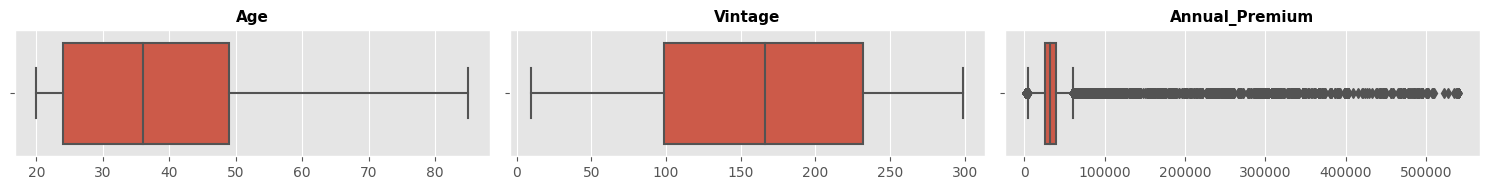

In [15]:
def draw_box_plots_for_numericals(cols_number=3, col_mul=3.0, row_mul=3.0):
    
    features = numerical_features
    rows_number = len(features)//cols_number + min(1, len(features)%cols_number)
    fig, axs = plt.subplots(rows_number, cols_number, figsize=(col_mul*cols_number, row_mul*rows_number))
    axs      = axs.ravel() 
    
    for i, col in enumerate(features):
        sns.boxplot(data=train, x=col, ax=axs[i])
        axs[i].set_title(col, fontsize=11, fontweight='bold')
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
    
    for i in range(len(features), rows_number*cols_number):
        axs[i].axis('off')
    
    #fig.suptitle(title, fontsize=15, fontweight='bold', y=.995)
    fig.tight_layout()
    
draw_box_plots_for_numericals(cols_number=3, col_mul=5.0, row_mul=2.0)

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">TARGET DISTRIBUTION</p>

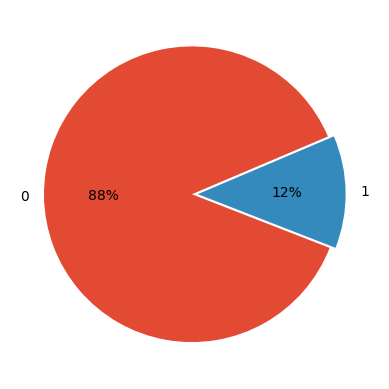

In [16]:
target_count = train.Response.value_counts()
fig, ax = plt.subplots()
ax.pie(x=target_count, labels=target_count.index, autopct='%1.0f%%', explode=[0.02, 0.02], startangle=23);

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 10px; padding: 15px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #06066F;">EDA: BIVARIATE AND MULTIVARIATE ANALYSIS</p>

In [17]:
def draw_violin_plots_for_numericals_1v_t(cols_number=3, col_mul=3.0, row_mul=3.0):
    
    features = numerical_features
    rows_number = len(features)//cols_number + min(1, len(features)%cols_number)
    fig, axs = plt.subplots(rows_number, cols_number, figsize=(col_mul*cols_number, row_mul*rows_number))
    axs      = axs.ravel() 
    
    for i, col in enumerate(features):
        sns.violinplot(data=train, x='Response', y=col, ax=axs[i])
        axs[i].set_xlabel('Response')
        axs[i].set_ylabel(col)
        if col=='Annual_Premium': axs[i].set(ylim=(0, 90000))
    
    for i in range(len(features), rows_number*cols_number):
        axs[i].axis('off')
    
    title = 'Violin Plots for Numerical Features by Response'
    fig.suptitle(title, fontsize=15, fontweight='bold', y=.995)
    fig.tight_layout()
    
#-------------------------------------------------------------------------------------------------

def draw_violin_plots_for_numericals_2v_t(second_feat, cols_number=3, col_mul=3.0, row_mul=3.0):
    
    features = numerical_features
    rows_number = len(features)//cols_number + min(1, len(features)%cols_number)
    fig, axs = plt.subplots(rows_number, cols_number, figsize=(col_mul*cols_number, row_mul*rows_number))
    axs      = axs.ravel() 
    
    for i, col in enumerate(features):
        sns.violinplot(data=train, x=second_feat, y=col, hue='Response', ax=axs[i], split=True, inner="quart")
        axs[i].set_xlabel(second_feat)
        if second_feat in ['Gender', 'Vehicle_Damage', 'Vehicle_Age']:
            xlabel = list(ordinal_encoder[second_feat].categories_[0])
            axs[i].set_xticklabels(xlabel)
        axs[i].set_ylabel(col)
        if col=='Annual_Premium': axs[i].set(ylim=(0, 90000))
        axs[i].legend(loc='best', title='Response')
    
    for i in range(len(features), rows_number*cols_number):
        axs[i].axis('off')
    
    title = f'Violin Plots for Numerical Features by {second_feat} and Response'
    fig.suptitle(title, fontsize=15, fontweight='bold', y=.995)
    fig.tight_layout()

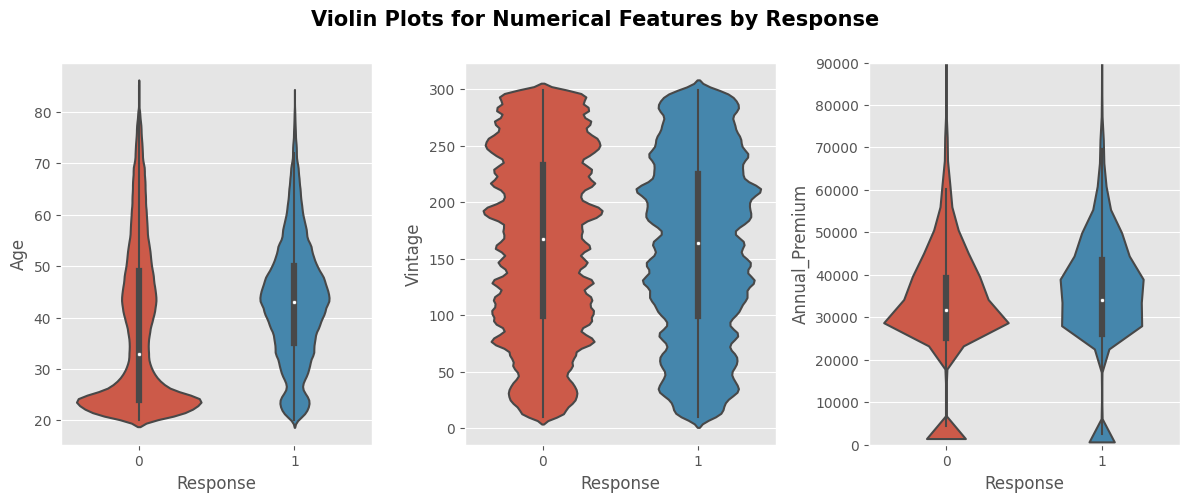

In [18]:
draw_violin_plots_for_numericals_1v_t(cols_number=3, col_mul=4.0, row_mul=5.0)

Looking at the graphs, we see:  
- For the "Age" feature: the median increases with the value of "Response".  
- For the "Vintage" feature: the medians are almost the same for different "Response" values.    
- For the "Premium_Annual" feature: the median increases slightly with the value of "Response".  

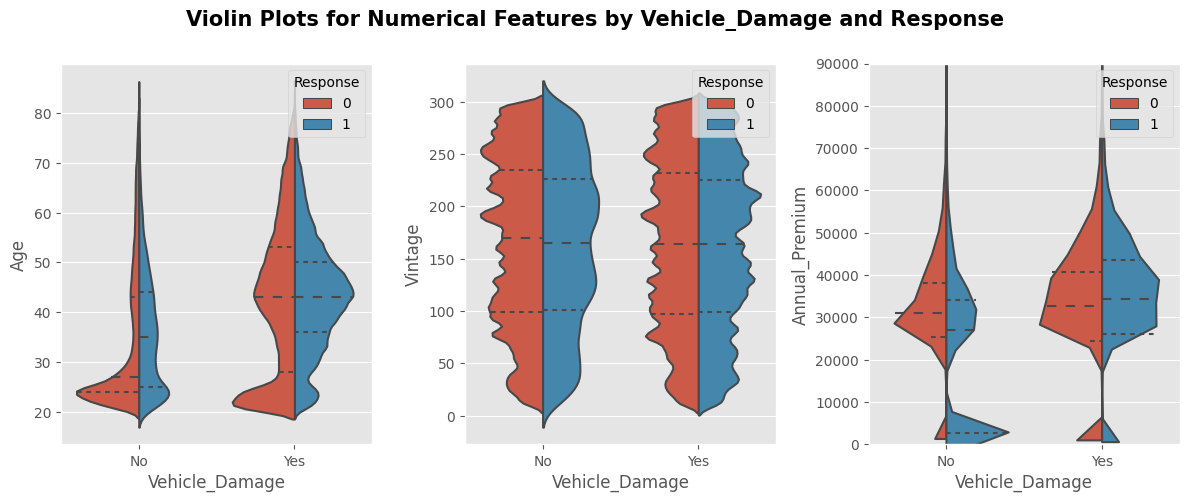

In [19]:
draw_violin_plots_for_numericals_2v_t(cols_number=3, col_mul=4.0, row_mul=5.0, second_feat='Vehicle_Damage')

Looking at the graphs, we see:
- For the "Age" feature: the median increases with the "Response" value only when the vehicle has not suffered damage in the past; otherwise, it remains the same.
- For the "Vintage" feature: the medians are almost the same for different "Response" and "Vehicle_Damage" values.
- For the "Premium_Annual" feature: the median decreases slightly with the "Response" value when the vehicle has not suffered damage in the past; otherwise, it increases slightly. 

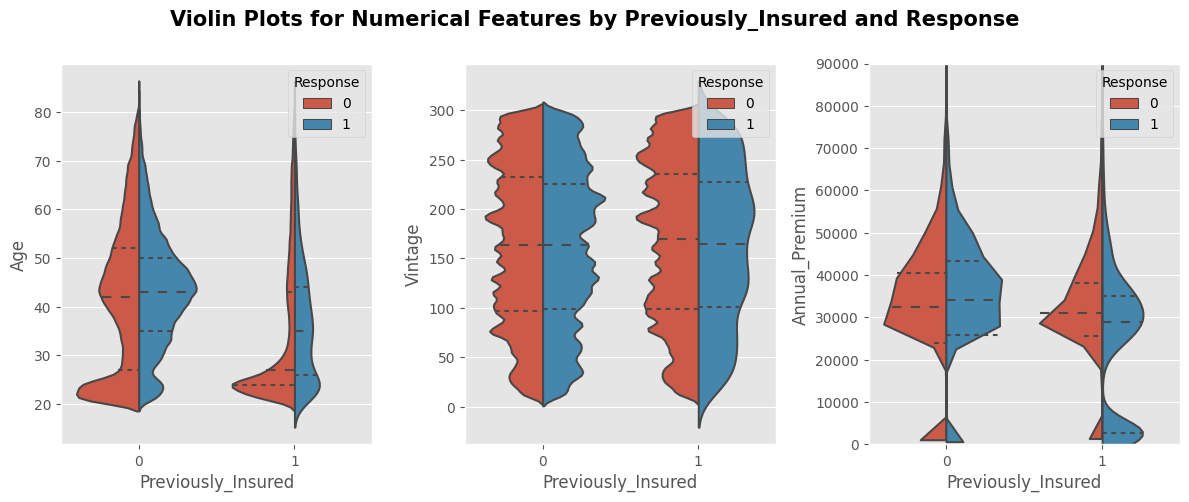

In [20]:
draw_violin_plots_for_numericals_2v_t(cols_number=3, col_mul=4.0, row_mul=5.0, second_feat='Previously_Insured')

Looking at the graphs, we see:
- For the "Age" feature: the median increases with the "Response" value and decreases when the person already has vehicle insurance.
- For the "Vintage" feature: the medians are almost the same for different "Response" and "Previously_Insured" values.
- For the "Premium_Annual" feature: the median increases slightly with the "Response" value when the person already has vehicle insurance; otherwise, it decreases slightly. 

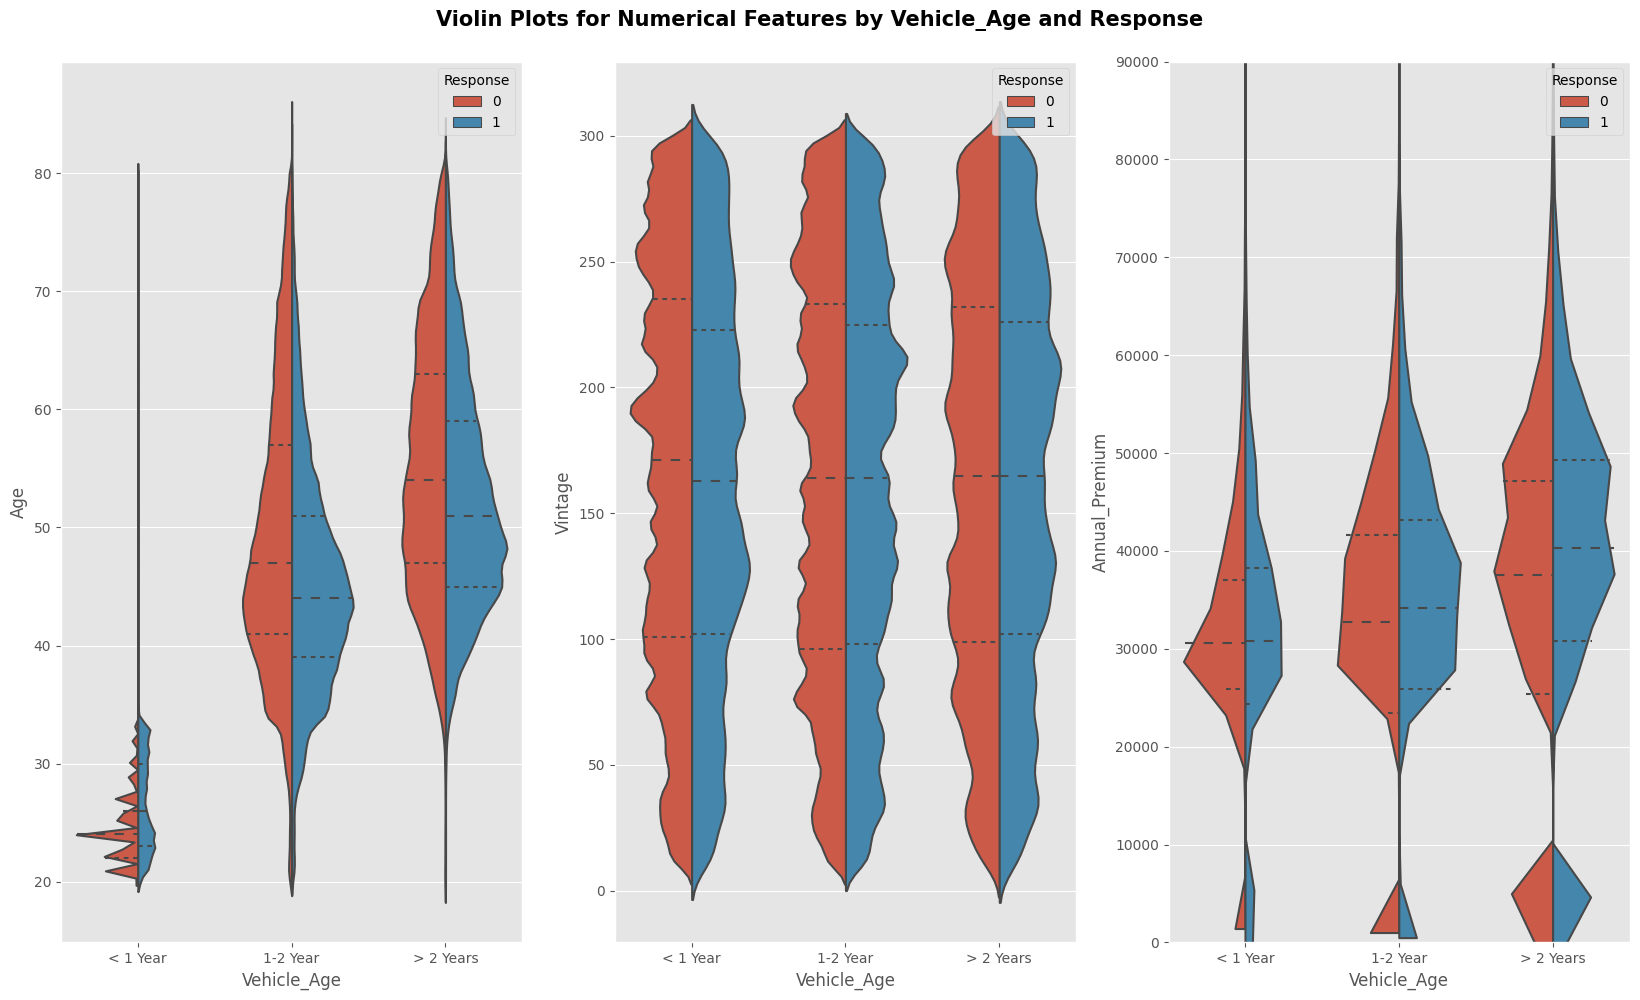

In [21]:
draw_violin_plots_for_numericals_2v_t(cols_number=3, col_mul=5.5, row_mul=10.0, second_feat='Vehicle_Age')

Looking at the graphs, we see:
- For the "Age" feature: the median increases with the "Response" value only when the vehicle is less than one year old; otherwise, it decreases. At the same time, the older the person, the older the car.   
- For the "Vintage" feature: the medians are almost the same for different "Response" and "Vehicle_Age" values.   
- For the "Premium_Annual" feature: the median increases with the "Response" and "Vehicle_Age" values.   

In [22]:
def draw_point_plots_2v_t(x, y, without_second_plot=False, col_mul=3.5, row_mul=2.5, estimator='median', pct_interval=50, dodge=True, hue='Response', scale=0.7):
    
    def get_mode(x):
        return stats.mode(x)[0]
    
    if y in categorical_features+['Response']:
        estimator_ = get_mode
        error_bar = None
        pct_interval = None
        title_est = 'Mode'
    else:
        estimator_ = estimator
        error_bar = ("pi", pct_interval)
        title_est = estimator.capitalize()
    
    if not without_second_plot:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(2 * col_mul, row_mul), sharey=True)
    else:
        fig, ax1 = plt.subplots(1,1, figsize=(col_mul, row_mul))

    sns.pointplot(data=train, x=x, y=y, estimator=estimator_, errorbar=error_bar, dodge=dodge, hue=hue, ax=ax1, scale=scale)
    ax1.set_xlabel(x, fontsize=10)
    ax1.set_ylabel(y, fontsize=10)
    if not without_second_plot:
        sns.pointplot(data=train, x=x, y=y, estimator=estimator_, errorbar=error_bar, dodge=dodge, color='black', ax=ax2, scale=scale)
        ax2.set_xlabel(x, fontsize=10)
        ax2.set_ylabel('')
    
    if x in binary_features + ['Vehicle_Age']:
        labels = list(ordinal_encoder[x].categories_[0]) if x in ['Gender', 'Vehicle_Damage', 'Vehicle_Age'] else ['No', 'Yes']
        ticks = range(len(labels))
        ax1.set_xticks(ticks=ticks, labels=labels)
        if not without_second_plot: ax2.set_xticks(ticks=ticks, labels=labels)
        
    if y in binary_features + ['Vehicle_Age']:
        labels = list(ordinal_encoder[y].categories_[0]) if y in ['Gender', 'Vehicle_Damage', 'Vehicle_Age'] else ['No', 'Yes']
        ticks = range(len(labels))
        ax1.set_yticks(ticks=ticks, labels=labels)
        if not without_second_plot: ax2.set_yticks(ticks=ticks, labels=labels)
    
    if train[x].nunique()>25:
        ax1.xaxis.set_major_locator(MultipleLocator(10)) 
        if not without_second_plot: ax2.xaxis.set_major_locator(MultipleLocator(10)) 
    
    title = f'{title_est} Value of {y} \nby {x} and {hue}'
    ax1.set_title(title, fontsize=12, fontweight='bold')
    ax1.legend(loc='best', title=hue)
    if not without_second_plot: 
        title = f'{title_est} Value of {y} \nby {x}'
        ax2.set_title(title, fontsize=12, fontweight='bold')
    
    fig.tight_layout()
    
#---------------------------------------------------------------------------------------------------  

def draw_point_plots_3v_t(x, y, z, col_mul=3.5, row_mul=2.5, estimator='median', pct_interval=50, hue='Response', scale=0.7, dodge=True):
    
    def get_mode(x):
        return stats.mode(x)[0]
    
    if y in categorical_features+['Response']:
        estimator_ = get_mode
        error_bar = None
        pct_interval = None
        title_est = 'Mode'
    else:
        estimator_ = estimator
        error_bar = ("pi", pct_interval)
        title_est = estimator.capitalize()
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(2 * col_mul, row_mul), sharey=True)

    sns.pointplot(data=train[train[z]==0], x=x, y=y, estimator=estimator_, errorbar=error_bar, dodge=dodge, hue=hue, ax=ax1, scale=scale)
    sns.pointplot(data=train[train[z]==1], x=x, y=y, estimator=estimator_, errorbar=error_bar, dodge=dodge, hue=hue, ax=ax2, scale=scale)
        
    if x in binary_features + ['Vehicle_Age']:
        labels = list(ordinal_encoder[x].categories_[0]) if x in ['Gender', 'Vehicle_Damage', 'Vehicle_Age'] else ['No', 'Yes']
        ticks = range(len(labels))
        ax1.set_xticks(ticks=ticks, labels=labels)
        ax2.set_xticks(ticks=ticks, labels=labels)
        
    if y in binary_features + ['Vehicle_Age']:
        labels = list(ordinal_encoder[y].categories_[0]) if y in ['Gender', 'Vehicle_Damage', 'Vehicle_Age'] else ['No', 'Yes']
        ticks = range(len(labels))
        ax1.set_yticks(ticks=ticks, labels=labels)
        ax2.set_yticks(ticks=ticks, labels=labels)
    
    ax1.set_xlabel(x, fontsize=10)
    ax2.set_xlabel(x, fontsize=10)
    ax1.set_ylabel(y, fontsize=10)
    ax2.set_ylabel('')
    zlabel = list(ordinal_encoder[z].categories_[0]) if z in ['Gender', 'Vehicle_Damage', 'Vehicle_Age'] else ['No', 'Yes']
    
    if train[x].nunique()>25:
        ax1.xaxis.set_major_locator(MultipleLocator(10)) 
        ax2.xaxis.set_major_locator(MultipleLocator(10)) 
    
    ax1.set_title(label=f'{z}={zlabel[0]}', fontsize=10)
    ax1.legend(loc='best', title=hue)
    
    ax2.set_title(label=f'{z}={zlabel[1]}', fontsize=10)
    ax2.legend(loc='best', title=hue)
    
    fig.suptitle(f'{title_est} Value of {y}', fontsize=12, fontweight='bold', y=.995)
    plt.tight_layout()
    
#-------------------------------------------------------------------------------------------------------------------    

def draw_point_plots_4v_t(x, y, row_var, col_var, col_mul=3.5, row_mul=2.5, estimator='median', pct_interval=50, hue='Response', scale=0.7, dodge=True):
    
    def get_mode(x):
        return stats.mode(x)[0]
    
    if y in categorical_features+['Response']:
        estimator_ = get_mode
        error_bar = None
        pct_interval = None
        title_est = 'Mode'
    else:
        estimator_ = estimator
        error_bar = ("pi", pct_interval) if pct_interval!=None else None
        title_est = estimator.capitalize()
    
    cols_number = train[col_var].nunique()
    rows_number = train[row_var].nunique()
    fig, axs = plt.subplots(rows_number, cols_number, figsize=(col_mul*cols_number, row_mul*rows_number), sharex=True, sharey=True)
    
    for i in range(rows_number):            
        for j in range(cols_number):
            sns.pointplot(data=train[(train[row_var]==i) & (train[col_var]==j)], x=x, y=y, estimator=estimator_, errorbar=error_bar, dodge=dodge, hue=hue, ax=axs[i,j], scale=scale)
            if i < rows_number-1: axs[i,j].set_xlabel('')
            else: axs[i,j].set_xlabel(x, fontsize=10)
            if j > 0: axs[i,j].set_ylabel('')
            else: axs[i,j].set_ylabel(y, fontsize=10)
    
    if x in binary_features + ['Vehicle_Age']:
        labels = list(ordinal_encoder[x].categories_[0]) if x in ['Gender', 'Vehicle_Damage', 'Vehicle_Age'] else ['No', 'Yes']
        ticks = range(len(labels))
        for j in range(cols_number): axs[rows_number-1,j].set_xticks(ticks=ticks, labels=labels)

    if y in binary_features + ['Vehicle_Age']:
        labels = list(ordinal_encoder[y].categories_[0]) if y in ['Gender', 'Vehicle_Damage', 'Vehicle_Age'] else ['No', 'Yes']
        ticks = range(len(labels))
        for i in range(rows_number): axs[i,0].set_yticks(ticks=ticks, labels=labels)

    if col_var in binary_features + ['Vehicle_Age']:
        labels = list(ordinal_encoder[col_var].categories_[0]) if col_var in ['Gender', 'Vehicle_Damage', 'Vehicle_Age'] else ['No', 'Yes']
    else: # nominal_features
        labels = list(ordinal_encoder[col_var].categories_[0]) 
    for j in range(cols_number): axs[0,j].set_title(f'{col_var} = {labels[j]}', fontsize=10)
    
    if row_var in binary_features + ['Vehicle_Age']:
        labels = list(ordinal_encoder[row_var].categories_[0]) if row_var in ['Gender', 'Vehicle_Damage', 'Vehicle_Age'] else ['No', 'Yes']
    else: # nominal_features
        labels = list(ordinal_encoder[row_var].categories_[0])
    for i in range(rows_number): 
        secay = axs[i, cols_number-1].secondary_yaxis('right')
        secay.set_yticks([])
        secay.set_ylabel(f'{row_var} = {labels[i]}', fontsize=10, rotation=-90, labelpad=20)
    
    if train[x].nunique()>25:
        for j in range(cols_number):
            axs[rows_number-1, j].xaxis.set_major_locator(MultipleLocator(10)) 
        
    fig.suptitle(f'{title_est} Value of {y}', fontsize=12, fontweight='bold', y=.995)
    fig.tight_layout()

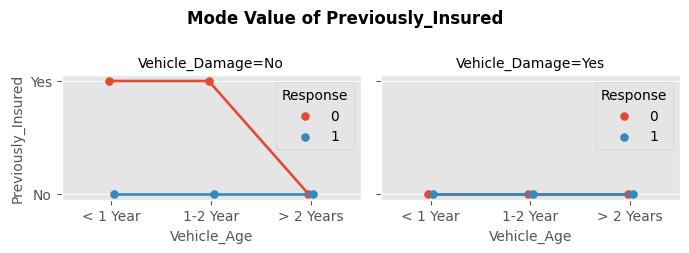

In [23]:
draw_point_plots_3v_t('Vehicle_Age', 'Previously_Insured', 'Vehicle_Damage', col_mul=3.5, row_mul=2.5)

We observe differences in the mode of "Previously_Insured" feature only when “Vehicle_Age” <= 2 years and the vehicle has not suffered damage in the past.

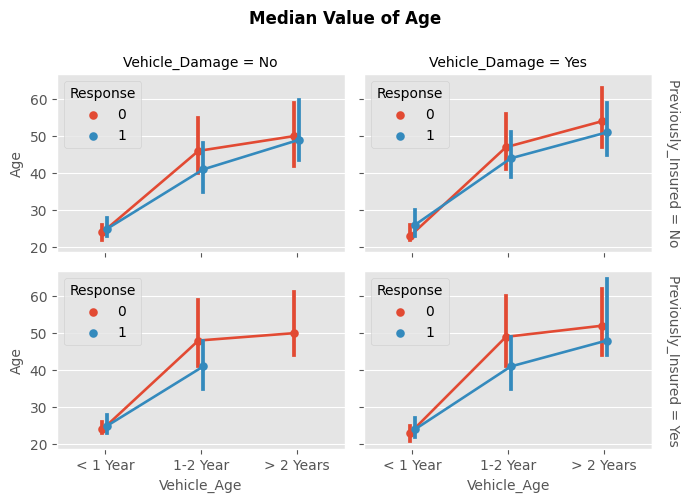

In [24]:
col_var, row_var, x, y = 'Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Age'
draw_point_plots_4v_t(x=x, y=y, row_var=row_var, col_var=col_var, col_mul=3.5, row_mul=2.5)

When "Vehicle_Age" >= 1 year, we observe a moderate difference in the median of “Age” feature; otherwise, the difference is very small.  

Obs. The error bar corresponds to the interquartile range.

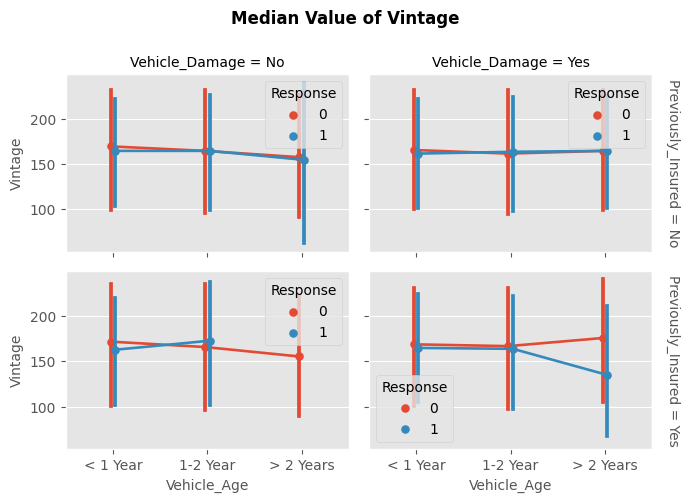

In [25]:
col_var, row_var, x, y = 'Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Vintage'
draw_point_plots_4v_t(x=x, y=y, row_var=row_var, col_var=col_var, col_mul=3.5, row_mul=2.5)

When "Vehicle_Age" > 2 years, we observe a great difference in the median of “Vintage” feature only if the person already has vehicle insurance.  

Obs. The error bar corresponds to the interquartile range.

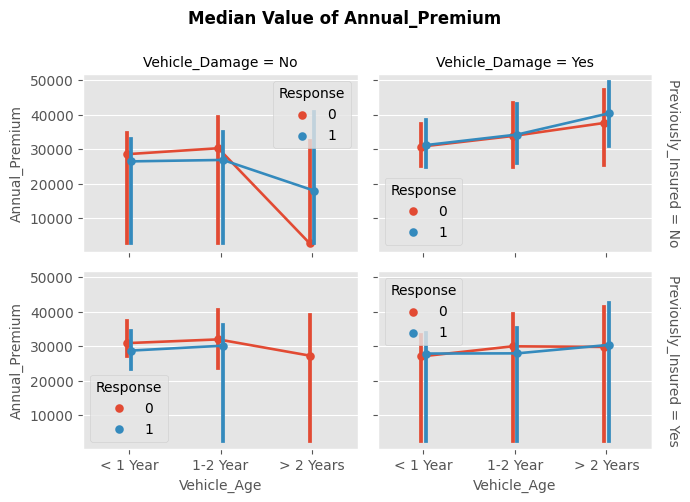

In [26]:
col_var, row_var, x, y = 'Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Annual_Premium'
draw_point_plots_4v_t(x=x, y=y, row_var=row_var, col_var=col_var, col_mul=3.5, row_mul=2.5)

When "Vehicle_Age" > 2 years, we observe a great difference in the median of “Annual_Premium” feature only if the vehicle has not suffered damage in the past.  

Obs. The error bar corresponds to the interquartile range.

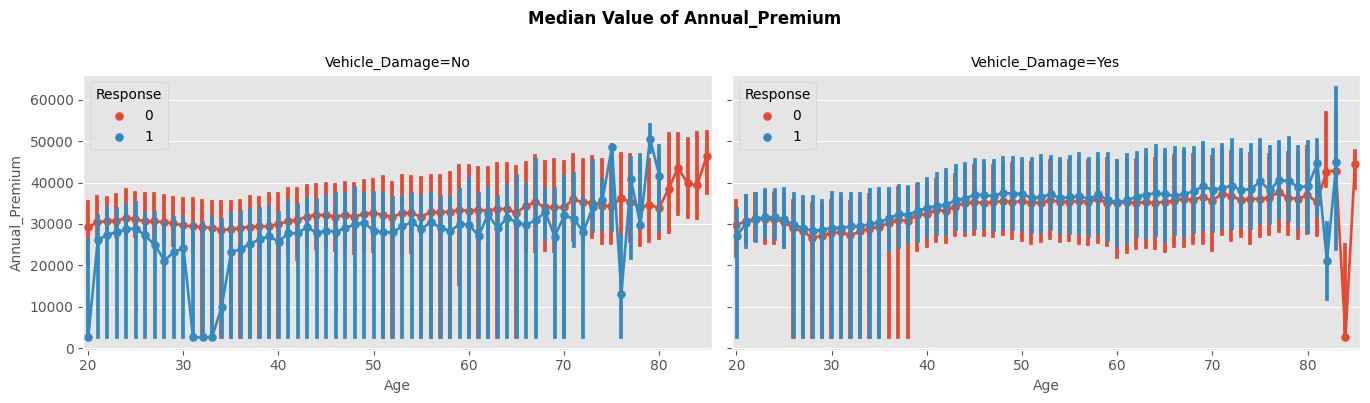

In [27]:
draw_point_plots_3v_t('Age', 'Annual_Premium', 'Vehicle_Damage', col_mul=6.9, row_mul=4.0)

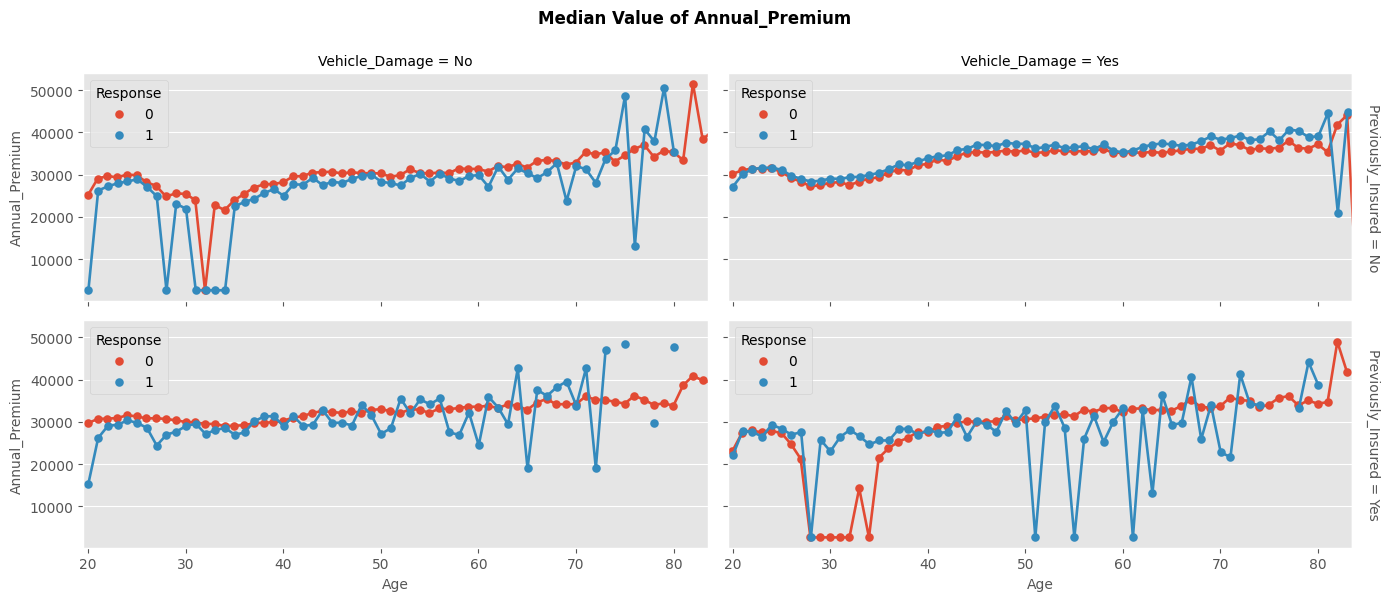

In [28]:
col_var, row_var, x, y = 'Vehicle_Damage', 'Previously_Insured', 'Age', 'Annual_Premium'
draw_point_plots_4v_t(x=x, y=y, row_var=row_var, col_var=col_var, col_mul=7.0, row_mul=3.0, pct_interval=None)

When the person does not have vehicle insurance, the median of the "Annual_Premium" feature tends to be higher (respectively lower) 
for the negative response relative to the positive response 
when the vehicle has not suffered damage in the past (respectively it has been damaged) for the entire age range.

Obs. The error bar corresponds to the interquartile range.

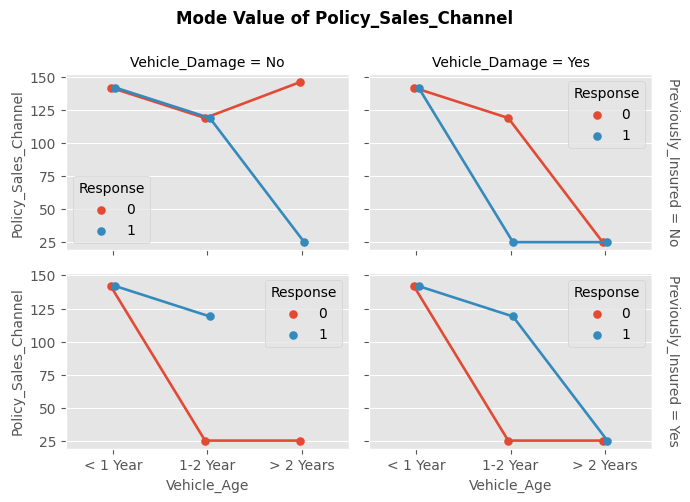

In [29]:
col_var, row_var, x, y = 'Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Policy_Sales_Channel'
draw_point_plots_4v_t(x=x, y=y, row_var=row_var, col_var=col_var, col_mul=3.5, row_mul=2.5)

We observe important differences in the mode of the "Policy_Sales_Channel" feature depending on the values of "Response" and "Vehicle_Age", 
"Vehicle_Damage" and "Previously_Insured" features.

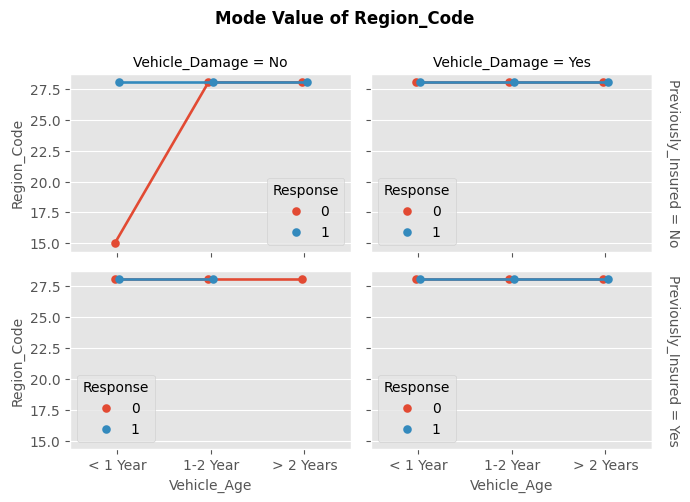

In [30]:
col_var, row_var, x, y = 'Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Region_Code'
draw_point_plots_4v_t(x=x, y=y, row_var=row_var, col_var=col_var, col_mul=3.5, row_mul=2.5)

We observe differences in the mode of "Region_Code" feature when the vehicle has not suffered damage and:   
- the person does not have vehicle insurance and "Vehicle_Age" < 1 year, or
- the person already has vehicle insurance and "Vehicle_Age" > 2 years.

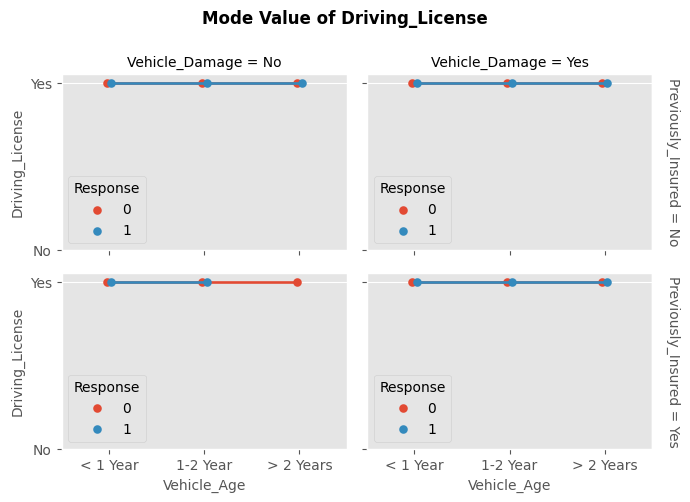

In [31]:
col_var, row_var, x, y = 'Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Driving_License'
draw_point_plots_4v_t(x=x, y=y, row_var=row_var, col_var=col_var, col_mul=3.5, row_mul=2.5)

We do not observe positive response values when the car is more than 2 years old and the person has a driving license and vehicle insurance.   

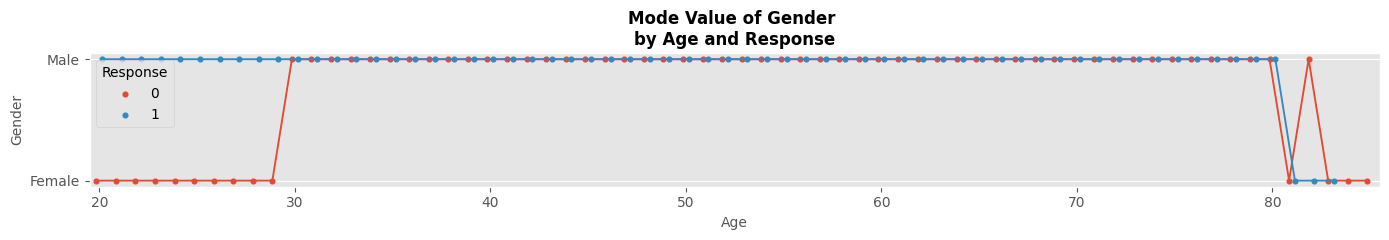

In [32]:
draw_point_plots_2v_t( 'Age', 'Gender', col_mul=14.0, row_mul=2.5, without_second_plot=True, scale=0.5, dodge=0.3)

Men (respectively women) aged 20 to 29 tend to have a positive (respectively negative) response.

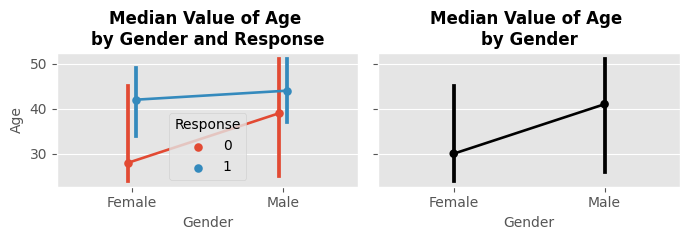

In [33]:
draw_point_plots_2v_t('Gender', 'Age', col_mul=3.5, row_mul=2.5)

The mean value of the "Age" feature tends to be lower for women compared to the value for men, both in positive and negative responses.
There is a larger difference in the median value of “Age” for women compared to the difference for men.  

Obs. The error bar corresponds to the interquartile range.

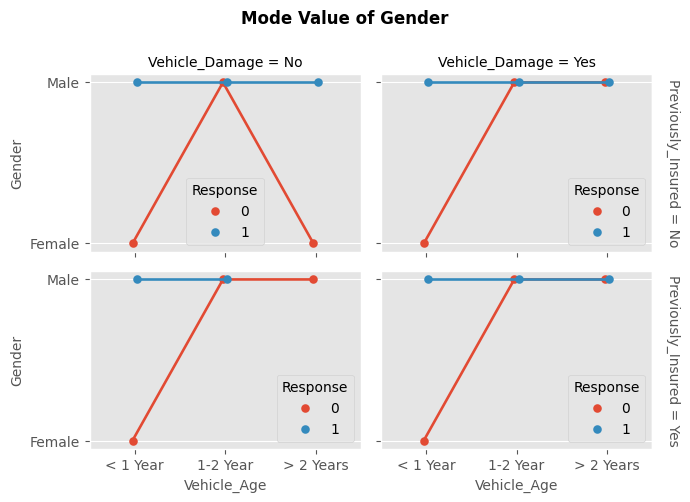

In [34]:
col_var, row_var, x, y = 'Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Gender'
draw_point_plots_4v_t(x=x, y=y, row_var=row_var, col_var=col_var, col_mul=3.5, row_mul=2.5)

We observe important differences in the mode of "Gender" feature when the vehicle is less than a year old or more than 2 years old.   

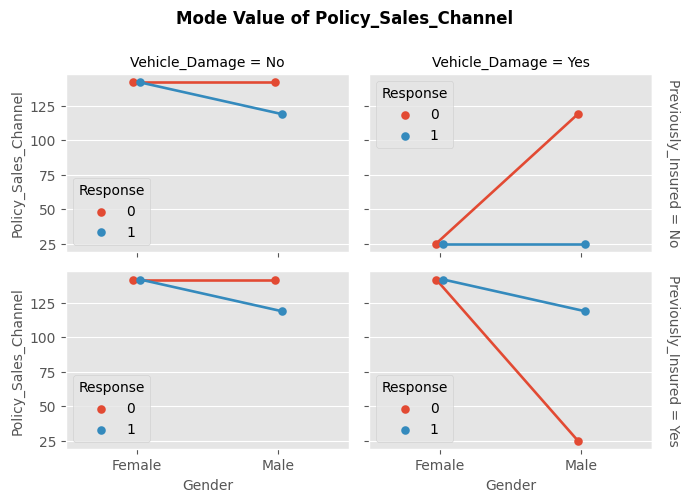

In [35]:
col_var, row_var, x, y = 'Vehicle_Damage', 'Previously_Insured', 'Gender', 'Policy_Sales_Channel'
draw_point_plots_4v_t(x=x, y=y, row_var=row_var, col_var=col_var, col_mul=3.5, row_mul=2.5)

We observe differences in the mode of "Policy_Sales_Channel" feature only for men, for both positive and negative responses.  

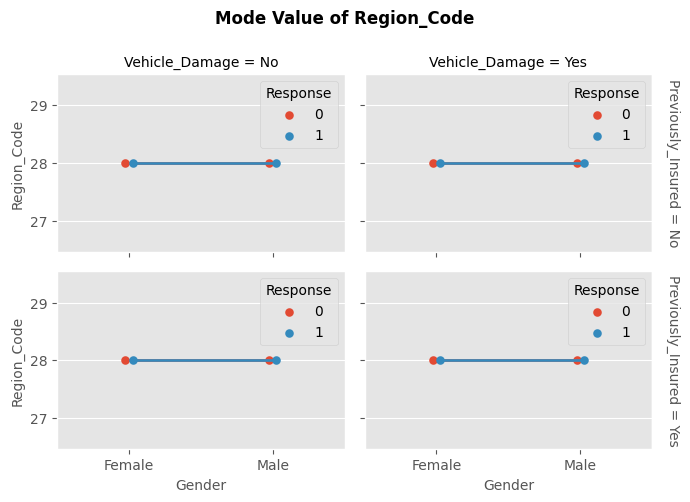

In [36]:
col_var, row_var, x, y = 'Vehicle_Damage', 'Previously_Insured', 'Gender', 'Region_Code'
draw_point_plots_4v_t(x=x, y=y, row_var=row_var, col_var=col_var, col_mul=3.5, row_mul=2.5)

We do not observe any difference in the mode of "Region_Code" feature.  

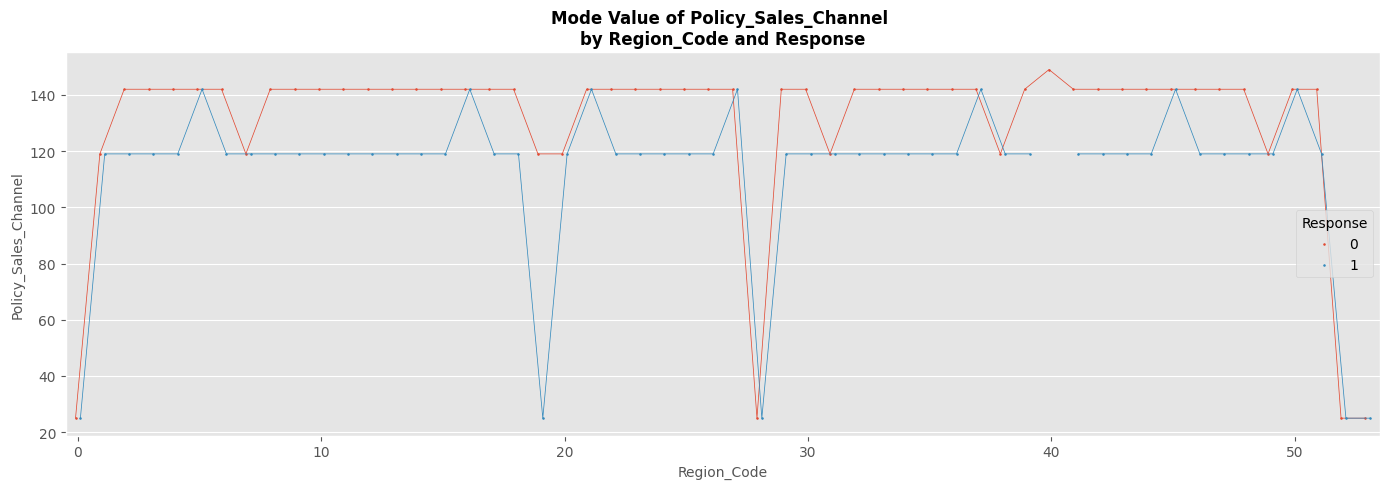

In [37]:
draw_point_plots_2v_t('Region_Code', 'Policy_Sales_Channel', col_mul=14.0, row_mul=5.0, scale=0.2, dodge=0.2, without_second_plot=True)

We observe that the mode of the "Policy_Sales_Channel" feature tends to be different for the entire range of "Region_Code" 
feature depending on whether it is a positive or negative response.

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">CORRELATION MATRIX ON TRAINING SET</p>

**Spearman Correlation** [1] is a non-parametric measure of rank correlation that assesses the strength and direction of association between two ranked variables. Unlike the Pearson correlation, which measures linear relationships, the Spearman correlation evaluates how well the relationship between two variables can be described using a monotonic function. This means it can capture both linear and non-linear associations.

As said in scipy stats [2] "*The Spearman correlation is a nonparametric measure of the linear relationship between two datasets. Unlike the Pearson correlation, 
the Spearman correlation does not assume that both datasets are normally distributed.*"   

So, since we know that no feature comes from a normal distribution and assuming that all categorical features are ordinal, which is not certain to be the case, 
we are going to calculate a correlation matrix with the Spearman method.   

References:   
[1] Spearman's rank correlation coefficient, https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient  
[2] Scipy stats, spearmanr, https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.spearmanr.html#scipy.stats.mstats.spearmanr

CPU times: user 21.7 s, sys: 1.76 s, total: 23.5 s
Wall time: 23.2 s


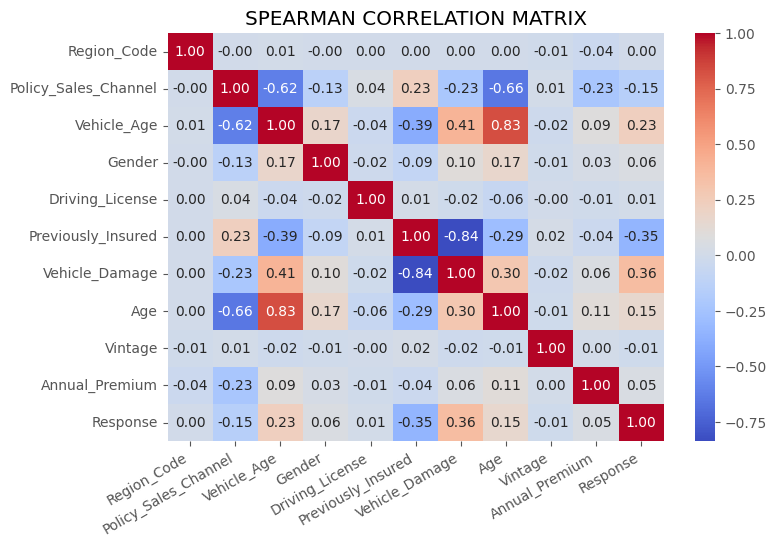

In [38]:
%%time

# Calculate Spearman correlation matrix
initial_features_response = categorical_features + numerical_features + ['Response']
corr_matrix = train[initial_features_response].corr(method='spearman')
plot_matrix(corr_matrix, figsize=(8,6), text="SPEARMAN CORRELATION MATRIX")

Analyzing the results we observe the following high correlations:   
- Vehicle_Damage with Previously_Insured (-0.84): Vehicle policyholders tend not to suffer damage to their cars, and vice versa (very strong correlation).   
- Age with Vehicle_Age (0.83): The older the person, the older the vehicle (very strong correlation).        
- Age with Policy_Sales_Channel (-0.66): The older the person, the lower the Sales Channel code (strong correlation).     
- Vehicle_Age with Policy_Sales_Channel (-0.62): The older the vehicle, the lower the Sales Channel code (strong correlation).   

Looking at the highest correlations between features and target, we only see two moderate correlations:   
- Vehicle_Damage with Response (0.36): Customers who have suffered damage to their vehicles show interest in purchasing vehicle insurance, and vice versa.    
- Previously_Insured with Response (-0.35): Customers without vehicle insurance show interest in purchasing vehicle insurance, and vice versa.   

Finally, there are three features that seem unrelated to any of the other features or the target: RegionCode, DrivingLicense and Vintage.

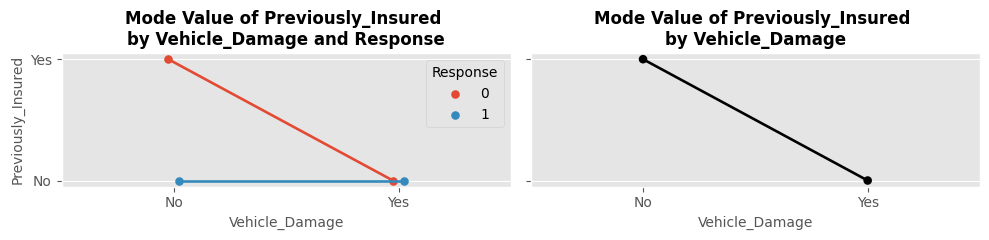

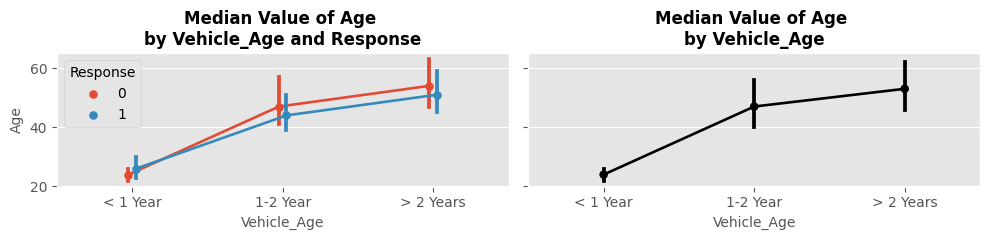

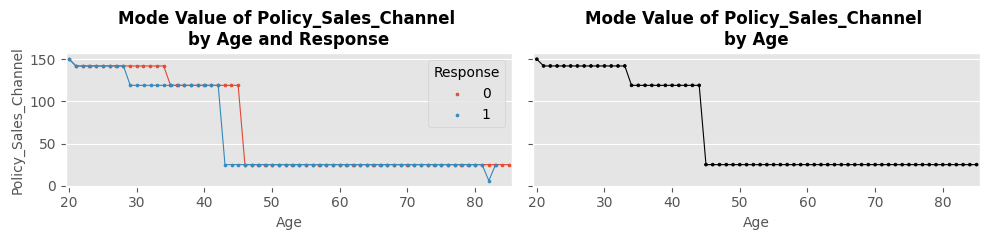

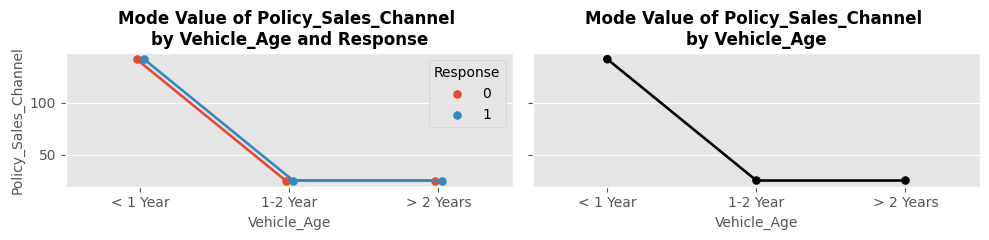

In [39]:
draw_point_plots_2v_t('Vehicle_Damage', 'Previously_Insured', col_mul=5.0, row_mul=2.5)
draw_point_plots_2v_t('Vehicle_Age', 'Age', col_mul=5.0, row_mul=2.5)
draw_point_plots_2v_t('Age', 'Policy_Sales_Channel', col_mul=5.0, row_mul=2.5, scale=0.3)
draw_point_plots_2v_t('Vehicle_Age', 'Policy_Sales_Channel', col_mul=5.0, row_mul=2.5)

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">CRAMÉR'S V</p>

**Cramér's V** [1] is a measure of association used to determine the strength of the relationship between two nominal (categorical) variables. It is based on the chi-squared statistic and provides a value between 0 and 1, where 0 indicates no association and 1 indicates a perfect association. 

References:   
[1] Cramér's V, https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

In [40]:
# Copied with edits from https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix

def cramers_corrected_stat(x,y):
    """ Calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        contingency_table=pd.crosstab(x, y)
            
        if contingency_table.shape[0]==2:
            correct=False
        else:
            correct=True
    
        chi2 = stats.chi2_contingency(contingency_table, correction=correct)[0]
            
        n = contingency_table.sum().sum()
        phi2 = chi2/n
        r,k = contingency_table.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
        
    return result

CPU times: user 1min 1s, sys: 15.5 s, total: 1min 16s
Wall time: 1min 16s


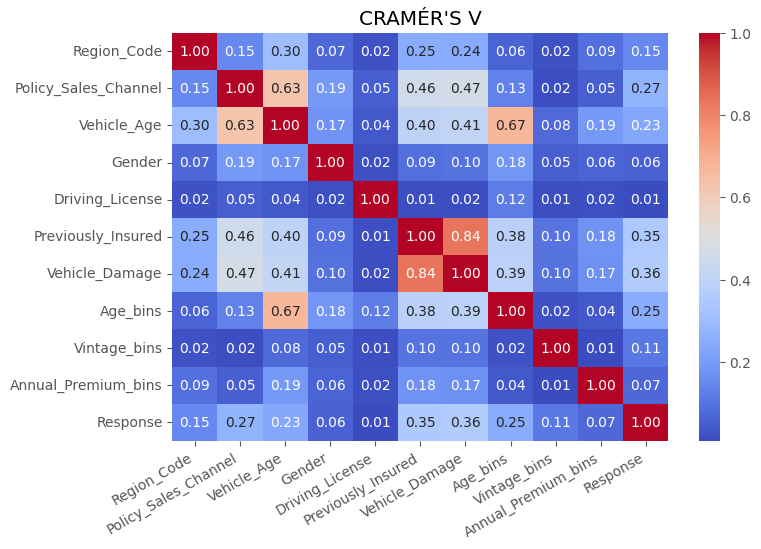

In [41]:
%%time

# Calculate Cramér's V matrix

# Binning numerical features
bins_features = []
for col in numerical_features:
    bins = train[col].nunique() if train[col].nunique() <= 100 else 100
    train[col+'_bins'] = pd.cut(train[col], bins=bins, labels=False)
    bins_features.append(col+'_bins')
      
int_features_response = categorical_features + bins_features + ['Response']

# Initializing Cramér's V matrix
cramer_info_matrix = pd.DataFrame(index=int_features_response, columns=int_features_response, data=1.0)

# Filling Cramér's V matrix
for i, col1 in enumerate(int_features_response[:-1]):
    for j, col2 in enumerate(int_features_response[i+1:]):
        cramer = cramers_corrected_stat(train[col1], train[col2])
        cramer_info_matrix[col1][col2] = cramer_info_matrix[col2][col1] = cramer
        
plot_matrix(cramer_info_matrix, figsize=(8, 6), text="CRAMÉR'S V")

Analyzing the results we observe:  
- A strong association for: Vehicle_Damage with Previously_Insured (0.84), Age_bins with Vehicle_Age (0.67), and Vehicle_age with Policy_Sales_Channel(0.63).   
- A moderate association for Vehicle_Damage with Response (0.36) and Previously_Insured with Response (0.35).   
- Features that seem unrelated to any of the other features or the target: Driving_License and Vintage_bins.

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">MUTUAL INFORMATION</p>

In probability theory and information theory, the **Mutual Information (MI)** [1] of two random variables is a measure of the mutual dependence between the two variables.  It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. 

References:   
[1] Mutual information, https://en.wikipedia.org/wiki/Mutual_information

CPU times: user 33min, sys: 37.9 s, total: 33min 38s
Wall time: 33min 34s


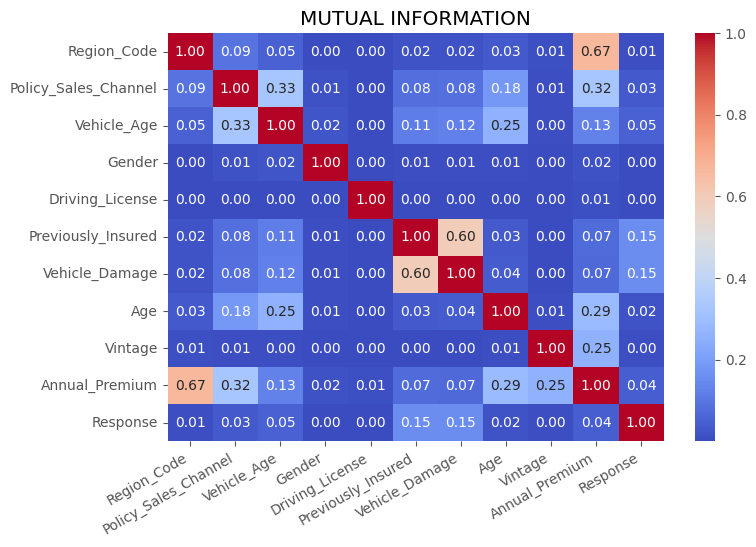

In [42]:
%%time

# Calculate Mutual Information matrix

initial_features_response = categorical_features + numerical_features + ['Response']

# Initializing matrix
mutual_info_matrix = pd.DataFrame(index=initial_features_response, columns=initial_features_response, data=1.0)

# Filling matrix
for i, col1 in enumerate(initial_features_response[:-1]):
    for j, col2 in enumerate(initial_features_response[i+1:]):
        if (col1 in categorical_features + discrete_features + ['Response']) and (col2 in categorical_features + discrete_features + ['Response']):
            mutual = adjusted_mutual_info_score(train[col1], train[col2])
        elif (col1 not in categorical_features + discrete_features + ['Response']) and (col2 in categorical_features + discrete_features + ['Response']):
            mutual = mutual_info_classif(train[col1].array.reshape(-1, 1), train[col2], discrete_features=False)
        elif (col1 in categorical_features + discrete_features + ['Response']) and (col2 not in categorical_features + discrete_features + ['Response']):
            mutual = mutual_info_classif(train[col2].array.reshape(-1, 1), train[col1], discrete_features=False)
        else:
            mutual = mutual_info_regression(train[col1].array.reshape(-1, 1), train[col2], discrete_features=False, random_state=0, n_jobs=-1)
        mutual_info_matrix[col1][col2] = mutual_info_matrix[col2][col1] = mutual
        
plot_matrix(mutual_info_matrix, figsize=(8, 6), text="MUTUAL INFORMATION")

Analyzing the results we observe:  
- A strong association for: Annual_Premium with Region_Code (0.67) and Vehicle_Damage with Previously_Insured (0.6).  
- A weak association for: Previously_Insured with Response (0.15) and Vehicle_Damage with Response (0.15).   
- Features that seem unrelated to any of the other features or the target: Driving_License and Gender.

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">SUMMARY OF THE RELATIONSHIP BETWEEN FEATURES AND TARGET</p>

Summarizing the results obtained for the Spearman Correlation, Cramér's V and Mutual Information methods between features and "Response, 
we see that the Previously_Insured and Vehicle_Damage features have the highest association with the target in the three cases.

Obs. The "spearman corr' column shows the absolute value of the Spearman correlation.

In [43]:
sp_corr = np.abs(corr_matrix.loc[initial_features, 'Response']) * 100
cramer_association = cramer_info_matrix.loc[:, 'Response'] * 100
new_index_values = {col:col.split('_bins')[0] for col in cramer_association.index}
cramer_association.rename(index=new_index_values, inplace=True)
cramer_association = cramer_association[initial_features]
mi_info = mutual_info_matrix.loc[initial_features, 'Response'] * 100

relation_degree = pd.DataFrame(index=initial_features, data={'spearman corr (abs)':sp_corr, "cramer's v":cramer_association, 'mutual info':mi_info})
relation_degree.style.background_gradient("Blues")

,spearman corr (abs),cramer's v,mutual info
Gender,5.521230,5.521152,0.289866
Age,15.368231,24.700292,1.606415
Driving_License,0.919699,0.919227,0.026765
Region_Code,0.106857,15.035460,0.649478
Previously_Insured,34.592983,34.592972,15.381516
Vehicle_Age,22.999837,23.116150,4.741025
Vehicle_Damage,35.977982,35.977972,15.388658
Annual_Premium,4.940899,7.447509,3.951947
Policy_Sales_Channel,15.156312,27.166489,3.485542
Vintage,1.496588,10.941425,0.451785


# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">HIERARCHICAL CLUSTERING OF FEATURES</p>

**Hierarchical Clustering** [1] is a method of cluster analysis that seeks to build a hierarchy of clusters. It is an unsupervised learning technique used to group similar objects into clusters, making it easier to understand the structure within a dataset.

Now we are going to perform Hierarchical Clustering to group similar features together.    

As a measure of similarity between features, we will use **Euclidean distance** along with **Ward's method** [2] 
to calculate distances between clusters.  

As stated in [3] and [4], "*we will only apply hierarchical clustering to the continuous features ... because we are using Euclidean distance*". 
It is also suggested that we could transform the categorical features into continuous ones using the Weight of Evidence (WoE) transformation beforehand and then apply hierarchical clustering; this is the approach we will use.

**Weight of Evidence (WoE)** [5] is a metric for evaluating the predictive power of categorical variables in distinguishing between binary outcomes, ensuring a monotonic relationship with the target variable and enhancing the effectiveness of predictive models. It is particularly used in credit scoring and risk modeling.

References:   
[1] Hierarchical clustering, https://en.wikipedia.org/wiki/Hierarchical_clustering   
[2] Ward's method, https://en.wikipedia.org/wiki/Ward%27s_method   
[3] Feature Selection using Hierarchical Clustering | Python Tutorial, https://www.youtube.com/watch?v=oymY1Iqollo   
[4] Feature Selection with Hierarchical Clustering for Interpretable Model, https://towardsdatascience.com/feature-selection-with-hierarchical-clustering-for-interpretable-models-a091802f24e0   
[5] WEIGHT OF EVIDENCE (WOE) AND INFORMATION VALUE (IV) EXPLAINED, https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html   

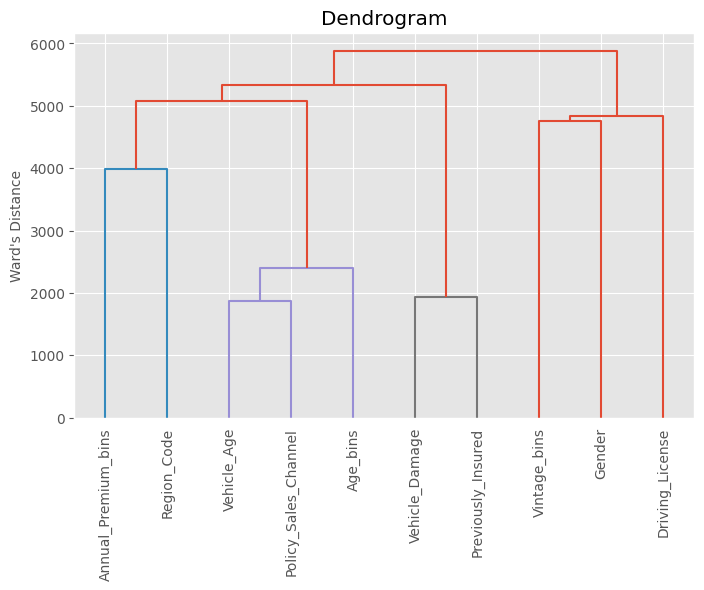

In [44]:
# Transform categorical features into continuous ones using the "weights of evidence" transformation

def calculate_woe(feature):
    '''Calculate Weight of Evidence (WoE).'''
    
    eps = 1e-10  # small value to avoid division by zero
    grouped = train.groupby(feature)['Response'].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    grouped['event_rate'] = grouped['sum'] / (grouped['sum'].sum() + eps)
    grouped['non_event_rate'] = grouped['non_event'] / (grouped['non_event'].sum() + eps)
    grouped['woe'] = np.log((grouped['event_rate'] + eps) / (grouped['non_event_rate'] + eps))
    return grouped['woe']


# Encode categorical features + numerical features (after binning) using WoE
woe_features = categorical_features + bins_features
woe_matrix = pd.DataFrame()
for feature in woe_features:
    woe = calculate_woe(feature)
    woe_matrix[feature] = train[feature].map(woe)

# Scale features
scaler = StandardScaler()
woe_matrix = scaler.fit_transform(woe_matrix)
woe_matrix = pd.DataFrame(woe_matrix, columns=woe_features)

# Transpose matrix to group by features
woe_matrix = woe_matrix.transpose()

# Perform hierarchical clustering 
linked = linkage(woe_matrix, method='ward', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(8,5))
dendrogram(linked, orientation='top', labels=woe_features, distance_sort='descending', leaf_rotation=90)
plt.title('Dendrogram')
plt.ylabel("Ward's Distance", fontsize=10)
plt.xticks(fontsize=10)
plt.show()

By looking at the dendrogram, we could group the features into 4 clusters:   
1. "Annual_Premium_bins" with "Region_Code",   
2. "Vehicle_Age" with " Policy_Sales_Channel" and "Age_bins",   
3. "Vehicle_Damage" with "Previously_Insured", and  
4. "Vintage_bins" with "Gender" and "Driving_License".   

To see how the features are related within and between those 4 clusters, we will calculate the Pearson correlation 
between the features using the "Weight of Evidence" matrix.

In [45]:
def plot_matrix_clusters(matrix, figsize, labels, woe_features, text=''):
    
    # sort clusters and features
    grouped_features = list(zip(labels, woe_features))
    
    features_clusters_dict = {}
    for k, feat in grouped_features:
        if k not in features_clusters_dict: features_clusters_dict[k] = []
        features_clusters_dict[k].append(feat)
        
    corr_label_list = []
    for l in set(labels):
        l1 = features_clusters_dict[l][:-1]
        l2 = features_clusters_dict[l][1:]
        avg_corr = []
        for i in l1:
            for j in l2:
                if i!=j:
                    avg_corr.append(np.abs(corr_woe_matrix.loc[i,j]))
        avg_corr = np.mean(avg_corr)
        corr_label_list.append([l, avg_corr])
    
    corr_label_list = sorted(corr_label_list, key=lambda x:x[1], reverse=True)
    sorted_labels = [l for l,j in corr_label_list]
    sorted_features = []
    n_features_per_cluster = []
    for l in sorted_labels:
        sorted_features.extend(features_clusters_dict[l])
        n_features_per_cluster.append(len(features_clusters_dict[l]))
    
    # plot correlation matrix with clusters
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(corr_woe_matrix.loc[sorted_features, sorted_features], annot=True, fmt=',.2f', cmap='coolwarm')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
    ax.set_title(text)
    fig.autofmt_xdate() # it helps to rotate ticklabels if they are long
    i = 0
    for j in n_features_per_cluster:
        rect = Rectangle((i,i), j, j, fill=False, edgecolor='black', linewidth=3)
        ax.add_patch(rect)
        i = i+j

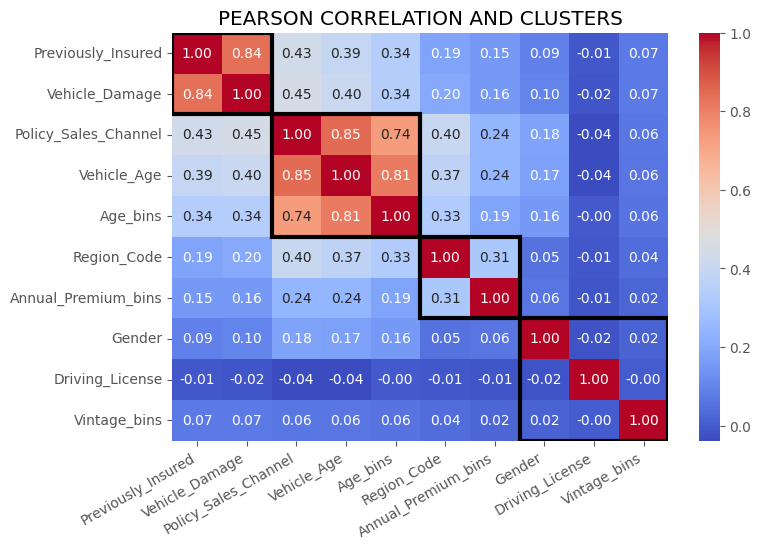

In [46]:
# Calculate Pearson correlation between features using woe_matrix (after transposition)
corr_woe_matrix = pd.concat([woe_matrix.T, train.Response], axis=1).corr(method='pearson')

num_clusters = 4 # group the features into 4 clusters
labels = fcluster(linked, t=num_clusters, criterion='maxclust') # assign cluster to features

# plot correlation matrix with clusters
plot_matrix_clusters(corr_woe_matrix, figsize=(8,6), labels=labels, woe_features=woe_features, text='PEARSON CORRELATION AND CLUSTERS')

"Gender", "Driving_License" and "Vintage_bins" seem unrelated to any of the other features.

Speaking of the relationship between features and "Response", it is interesting that the Pearson correlation (using woe_matrix) 
and Cramér's V association produces very similar results.

In [47]:
cramer_association = cramer_info_matrix.loc[:, 'Response'] * 100
woe_association = corr_woe_matrix.loc[:, 'Response'] * 100
relation_degree = pd.DataFrame(index=woe_features, data={'pearson woe corr':woe_association, "cramer's v":cramer_association})
relation_degree.style.background_gradient("Blues")

,pearson woe corr,cramer's v
Region_Code,14.893918,15.035460
Policy_Sales_Channel,26.877349,27.166489
Vehicle_Age,22.827044,23.116150
Gender,5.521230,5.521152
Driving_License,0.919699,0.919227
Previously_Insured,34.592983,34.592972
Vehicle_Damage,35.977982,35.977972
Age_bins,24.330934,24.700292
Vintage_bins,10.842932,10.941425
Annual_Premium_bins,7.368860,7.447509


# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">FACTOR ANALYSIS OF MIXED DATA</p>

**Factor Analysis of Mixed Data (FAMD)** [1] is a statistical technique that extends traditional factor analysis to handle datasets containing both numerical and categorical variables. It combines the principles of Principal Component Analysis (PCA) for numerical data and Multiple Correspondence Analysis (MCA) for categorical data to reduce the dimensionality of the dataset while preserving as much information as possible.  

We will use the **Prince** package [2] to perform the Factor Analysis of Mixed Data.  

References:  
[1] Factor analysis of mixed data, https://en.wikipedia.org/wiki/Factor_analysis_of_mixed_data   
[2] Prince package, Max Halford, https://github.com/MaxHalford/prince   
[3] Factor Analysis of Mixed Data, Prince package, https://maxhalford.github.io/prince/famd/

In [48]:
# The prince package requires categorical (respectively numeric) features to have integer (respectively float) types.
# Fix type of categorical and continuous features

train[categorical_features] = train[categorical_features].astype(np.int32)
train[numerical_features] = train[numerical_features].astype(np.float32)
print(f'Type of categorical features = {train[categorical_features].dtypes.unique()}')
print(f'Type of numerical features = {train[numerical_features].dtypes.unique()}')

Type of categorical features = [dtype('int32')]
Type of numerical features = [dtype('float32')]


In [49]:
%%time

# We will use only 20% of the train dataset so as not to run out of memory.

frac = 0.2 
random_for_frac = 1

# The Prince package one-hot encodes categorical variables and scales the continuous ones simultaneously
# The maximum number of components is equal to the number of numerical features plus the number of categories per feature (dropping the first category)

n_components_max = train[categorical_features].sample(frac=frac, random_state=random_for_frac).nunique().sum() - len(categorical_features) + len(numerical_features)
print(f'Maximum number of components = {n_components_max}')

# Instantiate FAMD object
famd = prince.FAMD(n_components=n_components_max, random_state=42)

# Fit FAMD object
famd = famd.fit(train[initial_features].sample(frac=frac, random_state=random_for_frac))

# Eigenvalues
famd.eigenvalues_summary

Maximum number of components = 207
CPU times: user 32min 27s, sys: 6min 41s, total: 39min 9s
Wall time: 32min 9s


,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,10.872,1.52%,1.52%
1,5.014,0.70%,2.22%
2,4.967,0.69%,2.91%
3,4.716,0.66%,3.57%
4,4.653,0.65%,4.22%
5,4.581,0.64%,4.85%
6,4.441,0.62%,5.47%
7,4.351,0.61%,6.08%
8,4.293,0.60%,6.68%


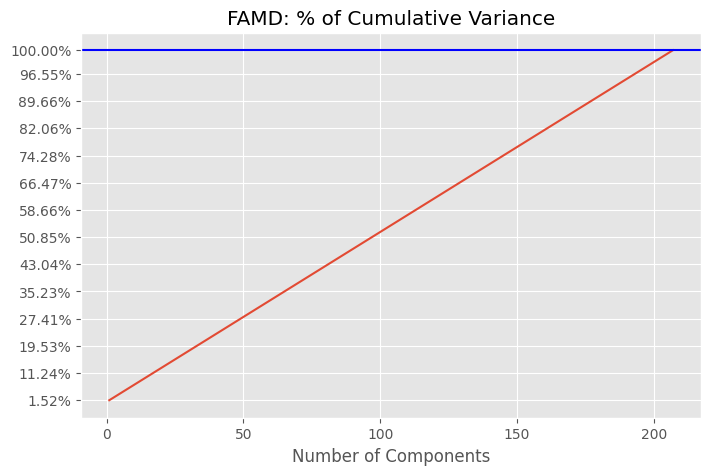

In [50]:
# Plot Cumulative Variance

plt.figure(figsize=(8,5))
plt.plot(range(1, n_components_max+1), famd.eigenvalues_summary['% of variance (cumulative)'])
plt.yticks(list(range(0, n_components_max, 16))+[n_components_max-1])
plt.axhline(y=n_components_max-1, c='b')
plt.xlabel('Number of Components')
plt.title('FAMD: % of Cumulative Variance')
plt.show()

From the graph it can be seen that all the components explain 100% of the variability of the data, so in a first analysis we could not ignore any feature.